In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.tree import plot_tree
from sklearn.model_selection import StratifiedKFold


In [2]:
df = pd.read_csv("Data/Darknet.csv")

In [3]:
df.head()

Flow ID         Src IP  Src Port  \
0     10.152.152.11-216.58.220.99-57158-443-6  10.152.152.11     57158   
1     10.152.152.11-216.58.220.99-57159-443-6  10.152.152.11     57159   
2     10.152.152.11-216.58.220.99-57160-443-6  10.152.152.11     57160   
3    10.152.152.11-74.125.136.120-49134-443-6  10.152.152.11     49134   
4  10.152.152.11-173.194.65.127-34697-19305-6  10.152.152.11     34697   

           Dst IP  Dst Port  Protocol               Timestamp  Flow Duration  \
0   216.58.220.99       443         6  24/07/2015 04:09:48 PM            229   
1   216.58.220.99       443         6  24/07/2015 04:09:48 PM            407   
2   216.58.220.99       443         6  24/07/2015 04:09:48 PM            431   
3  74.125.136.120       443         6  24/07/2015 04:09:48 PM            359   
4  173.194.65.127     19305         6  24/07/2015 04:09:45 PM       10778451   

   Total Fwd Packet  Total Bwd packets  ...  Active Mean  Active Std  \
0                 1                  1  ...            0           0   
1                 1                  1  ...            0           0   
2                 1                  1  ...            0           0   
3                 1                  1  ...            0           0   
4               591                400  ...            0           0   

   Active Max  Active Min     Idle Mean      Idle Std      Idle Max  \
0           0           0  0.000000e+00  0.000000e+00  0.000000e+00   
1           0           0  0.000000e+00  0.000000e+00  0.000000e+00   
2           0           0  0.000000e+00  0.000000e+00  0.000000e+00   
3           0           0  0.000000e+00  0.000000e+00  0.000000e+00   
4           0           0  1.437765e+15  3.117718e+06  1.437765e+15   

       Idle Min    Label          Label.1  
0  0.000000e+00  Non-Tor  AUDIO-STREAMING  
1  0.000000e+00  Non-Tor  AUDIO-STREAMING  
2  0.000000e+00  Non-Tor  AUDIO-STREAMING  
3  0.000000e+00  Non-Tor  AUDIO-STREAMING  
4  1.437765e+15  Non-Tor  AUDIO-STREAMING  

[5 rows x 85 columns]

In [4]:
print("Data types before type optimizattion")
df.info()

Data types before type optimizattion
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158616 entries, 0 to 158615
Data columns (total 85 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   Flow ID                     158616 non-null  object 
 1   Src IP                      158616 non-null  object 
 2   Src Port                    158616 non-null  int64  
 3   Dst IP                      158616 non-null  object 
 4   Dst Port                    158616 non-null  int64  
 5   Protocol                    158616 non-null  int64  
 6   Timestamp                   158616 non-null  object 
 7   Flow Duration               158616 non-null  int64  
 8   Total Fwd Packet            158616 non-null  int64  
 9   Total Bwd packets           158616 non-null  int64  
 10  Total Length of Fwd Packet  158616 non-null  int64  
 11  Total Length of Bwd Packet  158616 non-null  int64  
 12  Fwd Packet Length Max       158616 

# To improve efficiency, optimize the data type to the maximum data type that holds the max

In [6]:
def optimize_data_types(df):
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type == 'int64':
            # Check if the maximum value fits in a smaller integer type
            if df[col].max() < np.iinfo(np.int8).max:
                df[col] = df[col].astype(np.int8)
            elif df[col].max() < np.iinfo(np.int16).max:
                df[col] = df[col].astype(np.int16)
            elif df[col].max() < np.iinfo(np.int32).max:
                df[col] = df[col].astype(np.int32)
        
        elif col_type == 'float64':
            # Convert to float32 since we don't need that much percision 
            df[col] = df[col].astype(np.float32)
        
        elif col_type == 'object': # convert small object features to categories
            if df[col].nunique() < 0.5 * len(df):
                df[col] = df[col].astype('category')
    
    return df

In [7]:
# Apply optimization
df = optimize_data_types(df)
print("After Data Type Optimization")
print(df.info())

After Data Type Optimization
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158616 entries, 0 to 158615
Data columns (total 85 columns):
 #   Column                      Non-Null Count   Dtype   
---  ------                      --------------   -----   
 0   Flow ID                     158616 non-null  category
 1   Src IP                      158616 non-null  category
 2   Src Port                    158616 non-null  int32   
 3   Dst IP                      158616 non-null  category
 4   Dst Port                    158616 non-null  int32   
 5   Protocol                    158616 non-null  int8    
 6   Timestamp                   158616 non-null  category
 7   Flow Duration               158616 non-null  int32   
 8   Total Fwd Packet            158616 non-null  int32   
 9   Total Bwd packets           158616 non-null  int32   
 10  Total Length of Fwd Packet  158616 non-null  int32   
 11  Total Length of Bwd Packet  158616 non-null  int32   
 12  Fwd Packet Length Max       1

In [8]:
print("First Label value Counts")
print(df["Label"].value_counts())

First Label value Counts
Label
Non-Tor    110442
NonVPN      23863
VPN         22919
Tor          1392
Name: count, dtype: int64


In [9]:
print("Second Label value Counts")
df["Label.1"].value_counts()

Second Label value Counts


Label.1
P2P                48520
Browsing           46457
Audio-Streaming    19830
Chat               11629
File-Transfer      11098
Video-Streaming     9486
Email               6145
VOIP                3566
AUDIO-STREAMING     1520
Video-streaming      281
File-transfer         84
Name: count, dtype: int64

## The second Label has issues ragrading capitalization, fix it

In [11]:
df['Label.1'] = df['Label.1'].replace({
    'AUDIO-STREAMING': 'Audio-Streaming',
    'File-transfer': 'File-Transfer',
    'Video-streaming': 'Video-Streaming'
})

C:\Users\miran\AppData\Local\Temp\ipykernel_9148\1853558632.py:1: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  df['Label.1'] = df['Label.1'].replace({


In [12]:
print(df.describe())

            Src Port       Dst Port       Protocol  Flow Duration  \
count  158616.000000  158616.000000  158616.000000   1.586160e+05   
mean    38355.190599   17444.423684      10.220671   2.064569e+07   
std     19256.809575   22113.288014       5.398461   3.799717e+07   
min         0.000000       0.000000       0.000000   0.000000e+00   
25%     32916.000000      80.000000       6.000000   4.944250e+03   
50%     43533.000000    4070.000000       6.000000   4.169220e+05   
75%     53260.000000   39817.250000      17.000000   1.171051e+07   
max     65534.000000   65535.000000      17.000000   1.200000e+08   

       Total Fwd Packet  Total Bwd packets  Total Length of Fwd Packet  \
count     158616.000000      158616.000000                1.586160e+05   
mean         139.584058         142.036547                1.006577e+05   
std         2247.873161        3230.451392                3.071446e+06   
min            1.000000           0.000000                0.000000e+00   
25%     

## Detect impossible values

In [14]:

def detect_impossible_values(df):
    impossible_counts = []

    for col in df.columns:

        if pd.api.types.is_numeric_dtype(df[col]):
           
            inf_count = df[col].isin([np.inf, -np.inf]).sum()
            if inf_count > 0:
                impossible_counts.append({'Column': col, 'Reason': 'Inf/Negative Inf', 'Count': inf_count})
            
      
            nan_count = df[col].isnull().sum()
            if nan_count > 0:
                impossible_counts.append({'Column': col, 'Reason': 'NaN', 'Count': nan_count})

      
            if 'iat' in col.lower() or 'duration' in col.lower():
                negative_count = (df[col] < 0).sum()
                if negative_count > 0:
                    impossible_counts.append({'Column': col, 'Reason': 'Negative Time Value', 'Count': negative_count})
            
            # checks for Port and Protocol 
            if 'port' in col.lower():
                out_of_range_count = ((df[col] < 0) | (df[col] > 65535)).sum()
                if out_of_range_count > 0:
                    impossible_counts.append({'Column': col, 'Reason': 'Port Out of Range (0-65535)', 'Count': out_of_range_count})

            if 'protocol' in col.lower():
                unexpected_protocol_count = (~df[col].isin([6, 17, 1, 58, 132, 0])).sum()
                if unexpected_protocol_count > 0:
                    impossible_counts.append({'Column': col, 'Reason': 'Unexpected Protocol Value', 'Count': unexpected_protocol_count})
            
            # Check large header lengths
            if 'header length' in col.lower():
                large_header_count = (df[col] > 12000).sum()
                if large_header_count > 0:
                    impossible_counts.append({'Column': col, 'Reason': 'Impossible Header Length (>12000 bits)', 'Count': large_header_count})
            
   
            if 'flow bytes/s' in col.lower() or 'flow packets/s' in col.lower():
                inf_rate_count = (df[col] == np.inf).sum()
                if inf_rate_count > 0:
                    impossible_counts.append({'Column': col, 'Reason': 'Infinite Flow Rate', 'Count': inf_rate_count})

        elif pd.api.types.is_string_dtype(df[col]):
    
            empty_string_count = (df[col] == '').sum()
            if empty_string_count > 0:
                impossible_counts.append({'Column': col, 'Reason': 'Empty String', 'Count': empty_string_count})


    impossible_counts_df = pd.DataFrame(impossible_counts)


    if not impossible_counts_df.empty:
        impossible_counts_summary = impossible_counts_df.groupby(['Column', 'Reason']).sum().reset_index()
    else:
        impossible_counts_summary = pd.DataFrame(columns=['Column', 'Reason', 'Count'])

    return impossible_counts_summary


In [15]:
print("Count of impossible values: " )
print(detect_impossible_values(df))

Count of impossible values: 
              Column                                  Reason  Count
0  Bwd Header Length  Impossible Header Length (>12000 bits)   2622
1        Bwd IAT Min                     Negative Time Value     23
2       Flow Bytes/s                        Inf/Negative Inf      2
3       Flow Bytes/s                      Infinite Flow Rate      2
4       Flow Bytes/s                                     NaN     48
5       Flow IAT Min                     Negative Time Value    449
6     Flow Packets/s                        Inf/Negative Inf     50
7     Flow Packets/s                      Infinite Flow Rate     50
8  Fwd Header Length  Impossible Header Length (>12000 bits)   2639
9        Fwd IAT Min                     Negative Time Value     29


# Clean the data

In [17]:
le = LabelEncoder()
df['Src Port'] = le.fit_transform(df['Src Port'])
df['Dst Port'] = le.fit_transform(df['Dst Port'])

In [18]:
df["Src Port"].value_counts()

Src Port
2346     9118
8        6855
15       5692
14749     864
0         824
         ... 
3199        1
32502       1
23310       1
9099        1
32165       1
Name: count, Length: 34524, dtype: int64

In [19]:

#clip
header_length_cols = ['Bwd Header Length', 'Fwd Header Length']
df[header_length_cols] = df[header_length_cols].clip(upper=12000)



condition_bwd_iat_min = df['Bwd IAT Min'] < 0
condition_flow_iat_min = df['Flow IAT Min'] < 0
condition_fwd_iat_min = df['Fwd IAT Min'] < 0


df['Flow Bytes/s'] = df['Flow Bytes/s'].replace([np.inf, -np.inf], np.nan)
df['Flow Packets/s'] = df['Flow Packets/s'].replace([np.inf, -np.inf], np.nan)


condition_flow_bytes = df['Flow Bytes/s'].isna()
condition_flow_packets = df['Flow Packets/s'].isna()

# Combine all conditions
conditions = (
    condition_bwd_iat_min |
    condition_flow_iat_min |
    condition_fwd_iat_min |
    condition_flow_bytes |
    condition_flow_packets
)


df_cleaned = df[~conditions].reset_index(drop=True)

rows_dropped = df.shape[0] - df_cleaned.shape[0]
print(f"Number of rows dropped: {rows_dropped}")


df = df_cleaned

Number of rows dropped: 499


In [20]:

def find_duplicate_columns(df):
    """
    Finds duplicate columns in a DataFrame.
    
    Parameters:
        df (pd.DataFrame): The input DataFrame.
    
    Returns:
        list of duplicated columns
    """

    column_hash_map = {}
    duplicate_columns = []


    for col in df.columns:
        col_hash = df[col].apply(str).str.cat()  # Hashing column content 
        if col_hash in column_hash_map:
            duplicate_columns.append(col)  # Add duplicate column name
        else:
            column_hash_map[col_hash] = col

    # Create a DataFrame with the duplicate columns
    if duplicate_columns:
        return duplicate_columns
    else:
        return []  
        

duplicated_cols = find_duplicate_columns(df)
print("Duplicated columns", duplicated_cols)
print("Number of duplicates found",len(duplicated_cols))

Duplicated columns ['Fwd URG Flags', 'Bwd URG Flags', 'URG Flag Count', 'CWE Flag Count', 'ECE Flag Count', 'Fwd Segment Size Avg', 'Bwd Segment Size Avg', 'Fwd Bytes/Bulk Avg', 'Fwd Packet/Bulk Avg', 'Fwd Bulk Rate Avg', 'Bwd Bytes/Bulk Avg', 'Subflow Bwd Packets', 'Active Mean', 'Active Std', 'Active Max', 'Active Min']
Number of duplicates found 16


In [21]:
df.drop(columns = duplicated_cols,inplace=True)
print("shape after dropping duplicates: " , df.shape)

shape after dropping duplicates:  (158117, 69)


In [22]:

# Select all numeric columns, we don't have one hot encoded values
numeric_columns = df.select_dtypes(include=[np.number]).columns


scaler = StandardScaler()

# Apply the scaler to all numeric columns # since the labels are categorcal, and we don't have one hot encoded values scale all numeric columns
df[numeric_columns] = scaler.fit_transform(df[numeric_columns])



In [23]:
Label0= df["Label"] # save this label for later

## Run initial model for the first Label

In [25]:

last_label = df["Label.1"]
df = df.drop(columns="Label.1") # drop this beacasuse we don't want to have the other label as training data 


# Convert categorical labels to numeric using label encoder
le = LabelEncoder()
df['Label'] = le.fit_transform(df['Label'])  


"""we run the model on the numeric featues, all features are numeric apart from flow id, timestap and Ip addresses,
which are not good indicators or traffic"""
numeric_df = df.select_dtypes(include=['number'])

# Separate features and target variable
X = numeric_df.drop(columns=['Label'])  
y = numeric_df['Label']  # Target column


y = y.loc[X.index]

# Split the data into training and testing sets test size is 30%
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)


models_Label0 = {
    "Logistic Regression": LogisticRegression(max_iter=10000),
    "Random Forest": RandomForestClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Support Vector Machine": SVC(),
    "K-Nearest Neighbors": KNeighborsClassifier(),
}

# Train, make prediction, evaluate
results_Label0 = []
for model_name, model in models_Label0.items():
    model.fit(X_train, y_train)  
    y_pred = model.predict(X_test)  


    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

    # Store the results
    results_Label0.append(
        {
            "Model": model_name,
            "Accuracy": accuracy,
            "Precision": precision,
            "Recall": recall,
            "F1 Score": f1,
        }
    )

# Convert the results to a DataFrame and display
results_Label_0_df = pd.DataFrame(results_Label0)
print(results_Label_0_df)


                    Model  Accuracy  Precision    Recall  F1 Score
0     Logistic Regression  0.907201   0.903773  0.907201  0.903719
1           Random Forest  0.986698   0.986736  0.986698  0.986685
2           Decision Tree  0.981849   0.981855  0.981849  0.981851
3  Support Vector Machine  0.953474   0.952850  0.953474  0.952895
4     K-Nearest Neighbors  0.965195   0.964828  0.965195  0.964954


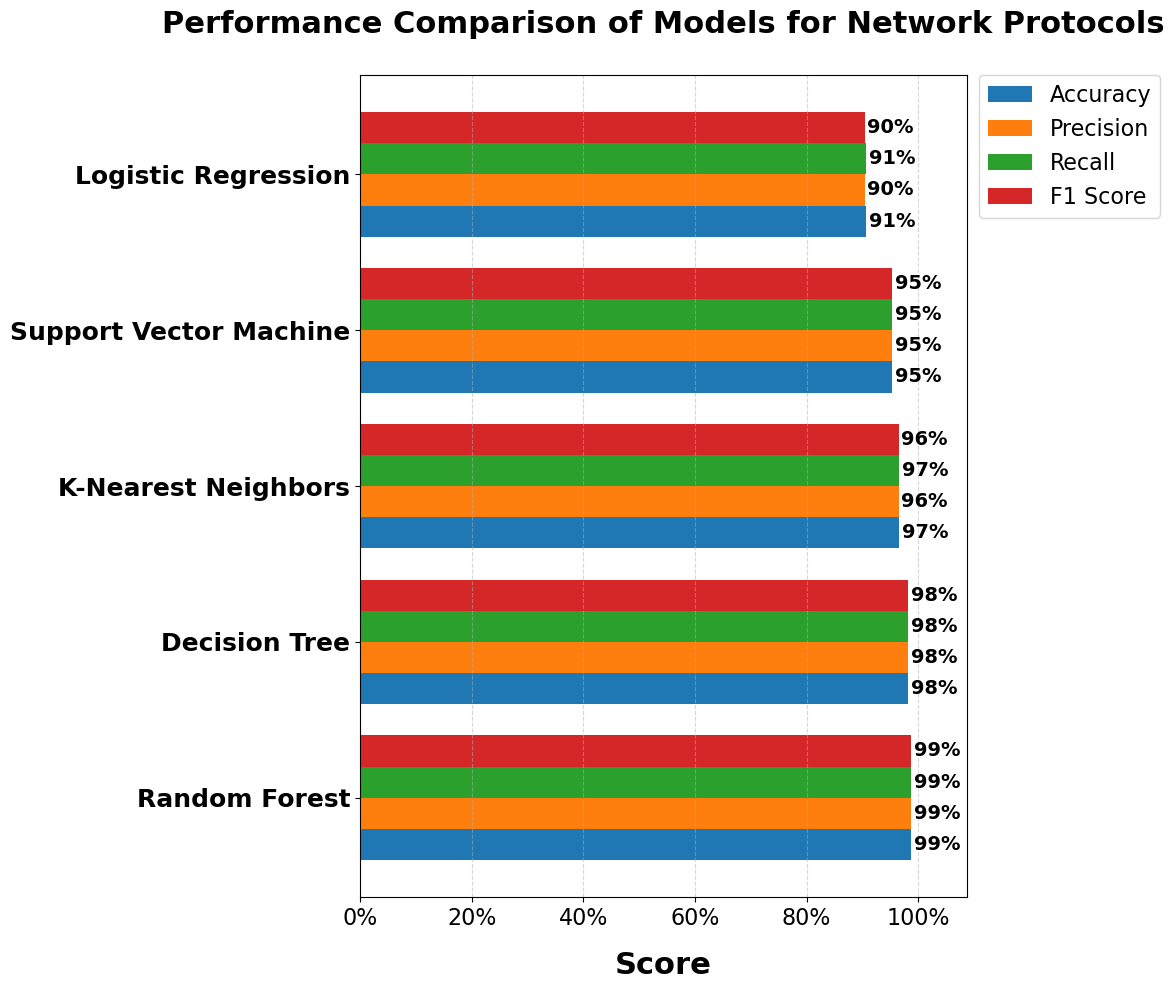

In [26]:
def visualize_model_performance(results_df,title, metrics=['Accuracy', 'Precision', 'Recall', 'F1 Score']):
    """
   
    Parameters:
        results_df  this is the model anme and their metrics
        metrics (list): this is the selected metrics for visalizaton.

    Returns:
        None
    """

    results_df['Average Score'] = results_df[metrics].mean(axis=1)
    results_df.sort_values(by='Average Score', ascending=False, inplace=True)
    results_df.reset_index(drop=True, inplace=True)

  
    models = results_df['Model']
    n_models = len(models)
    n_metrics = len(metrics)
    index = np.arange(n_models)  # Create evenly spaced numbers for the y-axis
    bar_height = 0.2


    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

  
    fig, ax = plt.subplots(figsize=(14, 10))


    for i, metric in enumerate(metrics):
        # Calculate positions for bars
        positions = index - ((n_metrics - 1) / 2 - i) * bar_height
        ax.barh(positions, results_df[metric], height=bar_height, label=metric, color=colors[i])

    
    ax.set_yticks(index)
    ax.set_yticklabels(models, fontsize=18, fontweight='bold')

 
    ax.set_xlabel('Score', fontsize=22, fontweight='bold', labelpad=15)
    ax.set_title('Performance Comparison of Models for ' + title, fontsize=22, fontweight='bold', pad=30)


    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '{:.0%}'.format(x)))
    ax.tick_params(axis='x', labelsize=16)


    ax.grid(True, axis='x', linestyle='--', alpha=0.5)


    ax.legend(fontsize=16, loc='upper left', bbox_to_anchor=(1.02, 1), borderaxespad=0)


    plt.tight_layout(rect=[0, 0, 0.85, 1])

    # Add annotations to bars
    for i, metric in enumerate(metrics):
        for j, model in enumerate(models):
            value = results_df.loc[j, metric]
            position = j - ((n_metrics - 1) / 2 - i) * bar_height
            ax.text(value + 0.005, position, '{:.0%}'.format(value),
                    va='center', ha='left', fontsize=14, fontweight='bold', color='black')


    ax.set_xlim(0, results_df[metrics].values.max().max() + 0.1)

    # Show the plot
    plt.show()


visualize_model_performance(results_Label_0_df,"Network Protocols")

# Run the model for the other label

In [28]:
# add back the label
df["Label.1"]= last_label

## Do the same for the other label

In [30]:

Label0= df["Label"] # save this for later


if "Label" in df.columns:
    df = df.drop(columns="Label")



df.dropna(inplace=True)




le_LabelOne = LabelEncoder()
df['Label.1'] = le_LabelOne.fit_transform(df['Label.1'])

# Select numeric columns and include Label.1
numeric_df = df.select_dtypes(include=['number'])

# Separate features and target variable
X = numeric_df.drop(columns=['Label.1'])  
y = numeric_df['Label.1']  


# Split the data into training and testing sets again we take 30% out for testing
X_train, X_test, y_train, y_test_LabelOne = train_test_split(
    X, y, test_size=0.3, random_state=42
)


models_LabelOne = {
    "Logistic Regression": LogisticRegression(max_iter=10000),
    "Random Forest": RandomForestClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Support Vector Machine": SVC(),
    "K-Nearest Neighbors": KNeighborsClassifier(),
}


results = []
for model_name, model in models_LabelOne.items():
    print(f"\nTraining {model_name}...")
    model.fit(X_train, y_train) 
    y_pred = model.predict(X_test)  
    

    accuracy = accuracy_score(y_test_LabelOne, y_pred)
    precision = precision_score(y_test_LabelOne, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test_LabelOne, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test_LabelOne, y_pred, average='weighted', zero_division=0)
    

    results.append({
        "Model": model_name,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1,
    })


results_df_Label1 = pd.DataFrame(results)
print("\nModel Performance Comparison:")
print(results_df_Label1)


Training Logistic Regression...

Training Random Forest...

Training Decision Tree...

Training Support Vector Machine...

Training K-Nearest Neighbors...

Model Performance Comparison:
                    Model  Accuracy  Precision    Recall  F1 Score
0     Logistic Regression  0.700523   0.686273  0.700523  0.669669
1           Random Forest  0.914748   0.913476  0.914748  0.913632
2           Decision Tree  0.913041   0.913139  0.913041  0.913073
3  Support Vector Machine  0.813454   0.811368  0.813454  0.795303
4     K-Nearest Neighbors  0.851547   0.845513  0.851547  0.847006


## Now check how the models perform on the different classes, starting with the first label

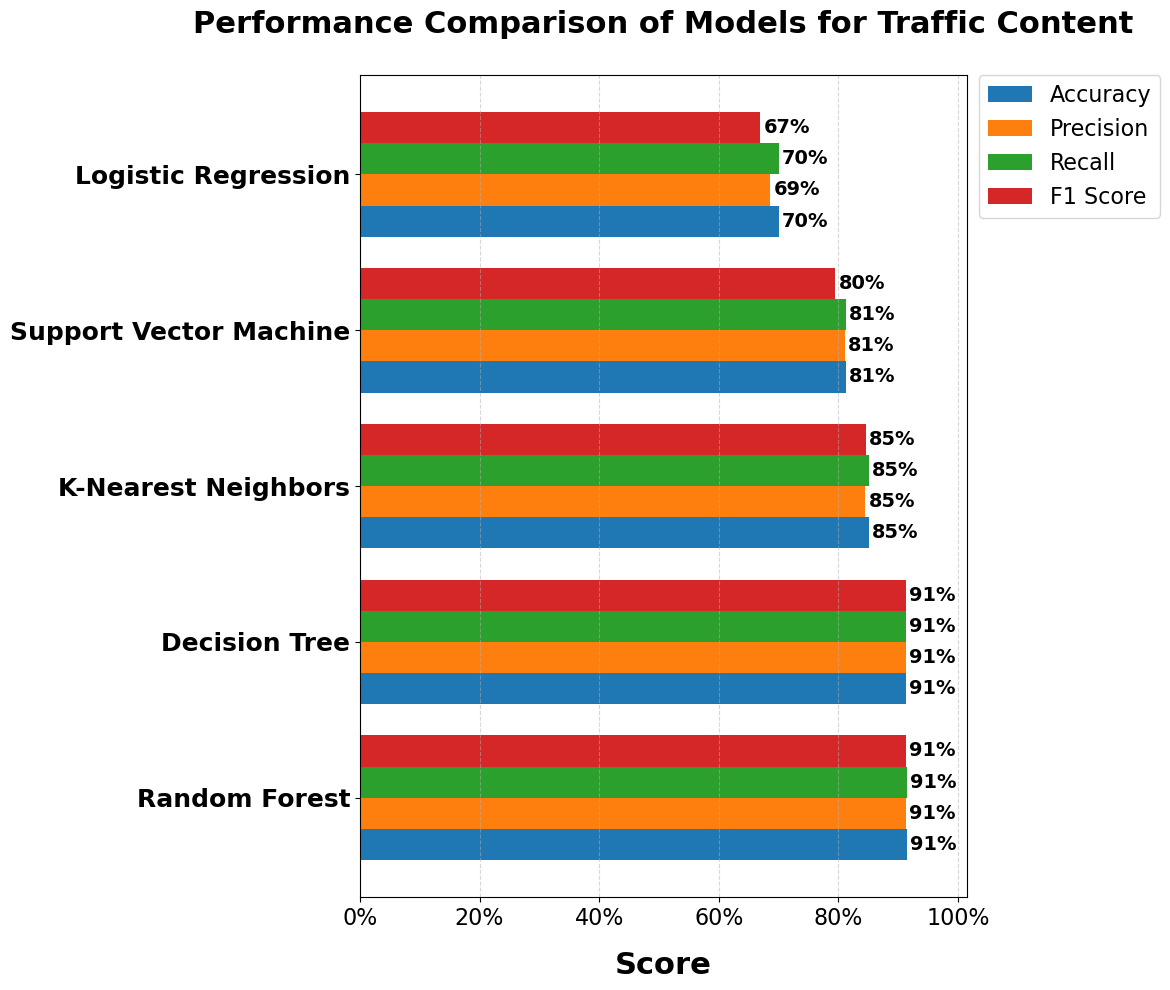

In [32]:

visualize_model_performance(results_df_Label1,"Traffic Content")


## Examine the First Label and see the performance accross different Classes

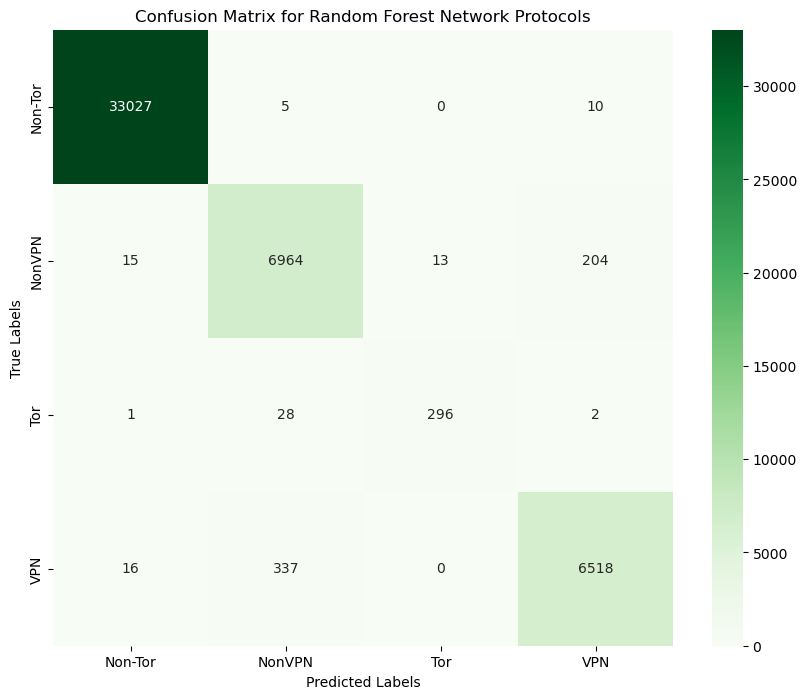

Classification Report for Random Forest Network Protocols:

              precision    recall  f1-score   support

     Non-Tor       1.00      1.00      1.00     33042
      NonVPN       0.95      0.97      0.96      7196
         Tor       0.96      0.91      0.93       327
         VPN       0.97      0.95      0.96      6871

    accuracy                           0.99     47436
   macro avg       0.97      0.96      0.96     47436
weighted avg       0.99      0.99      0.99     47436





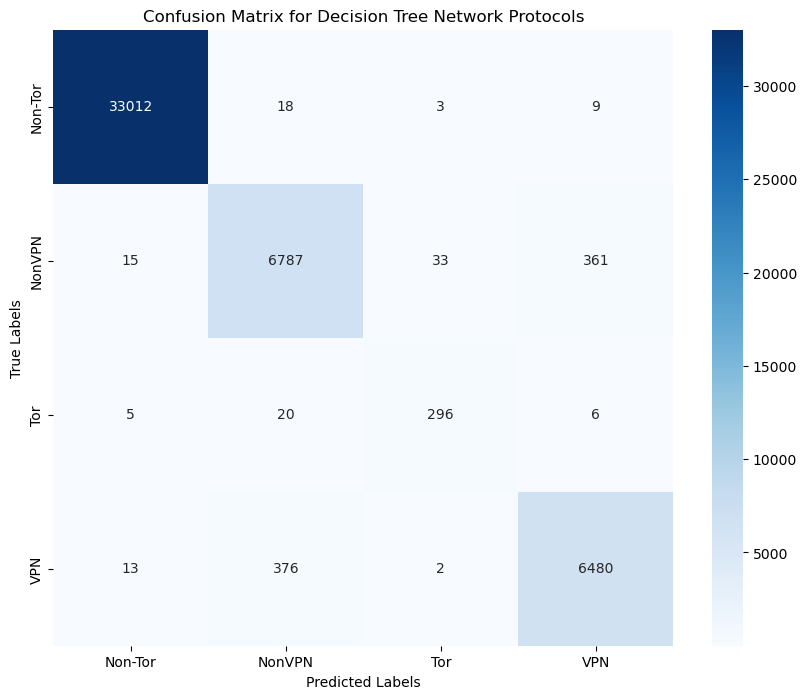

Classification Report for Decision Tree Network Protocols:

              precision    recall  f1-score   support

     Non-Tor       1.00      1.00      1.00     33042
      NonVPN       0.94      0.94      0.94      7196
         Tor       0.89      0.91      0.90       327
         VPN       0.95      0.94      0.94      6871

    accuracy                           0.98     47436
   macro avg       0.94      0.95      0.95     47436
weighted avg       0.98      0.98      0.98     47436





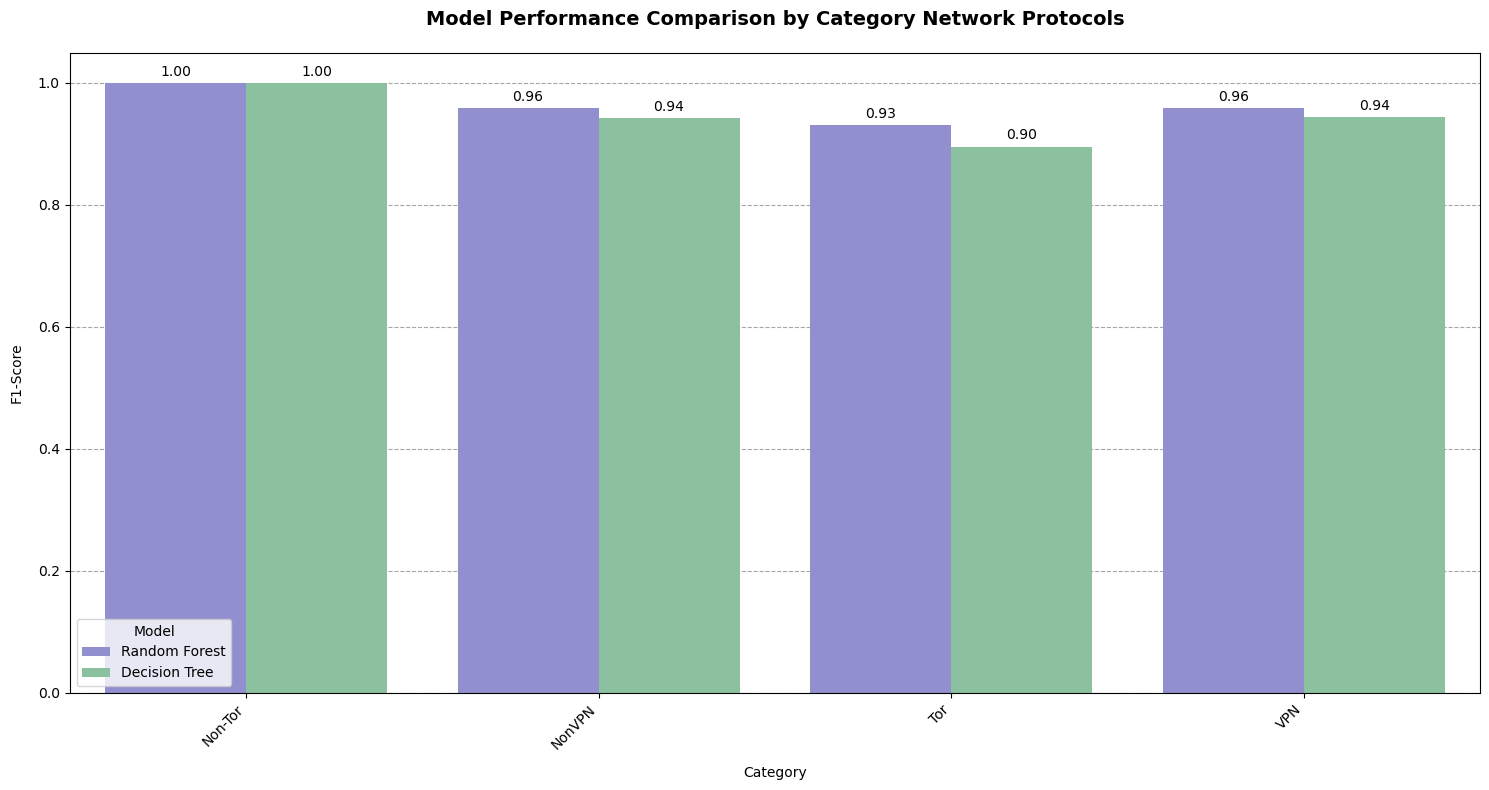


Detailed Performance Comparison:
         Random Forest F1-Score  Decision Tree F1-Score  Difference
Non-Tor                   0.999                   0.999      -0.000
NonVPN                    0.959                   0.943      -0.016
Tor                       0.931                   0.896      -0.035
VPN                       0.958                   0.944      -0.014

Positive values in 'Difference' column indicate the second model performed better.


In [34]:

def evaluate_and_compare_models(models, X_test, y_test, label_encoder, label_title=""):
  
    predictions = {}
    f1_scores = {}

    def get_f1_scores_per_class(y_true, y_pred, classes):
        """Calculate F1 scores for each class."""
        scores = {}
        for i, class_name in enumerate(classes):
            scores[class_name] = f1_score(y_true == i, y_pred == i, zero_division=0)
        return scores

    for model_name, model in models.items():
      
        y_pred = model.predict(X_test)
        predictions[model_name] = y_pred  

        conf_matrix = confusion_matrix(y_test, y_pred)

        plt.figure(figsize=(10, 8))
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues' if 'Tree' in model_name else 'Greens',
                    xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
        plt.title(f'Confusion Matrix for {model_name} {label_title}'.strip())
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.show()


        class_report = classification_report(y_test, y_pred, target_names=label_encoder.classes_)
        print(f"Classification Report for {model_name} {label_title}:\n")
        print(class_report)
        print("\n" + "=" * 80 + "\n")


        f1_scores[model_name] = get_f1_scores_per_class(y_test, y_pred, label_encoder.classes_)

    
    if f1_scores:
        categories = list(label_encoder.classes_)
        data = {
            'Category': categories * len(models),
            'Model': [name for name in models for _ in categories],
            'F1-Score': [f1 for scores in f1_scores.values() for f1 in scores.values()]
        }
        df_performance = pd.DataFrame(data)

     
        plt.style.use('default')
        plt.figure(figsize=(15, 8), facecolor='white')
        ax = sns.barplot(x='Category', y='F1-Score', hue='Model', data=df_performance,
                         palette=['#8884d8', '#82ca9d'])

       
        plt.title(f'Model Performance Comparison by Category {label_title}', pad=20, size=14, fontweight='bold')
        plt.xlabel('Category', labelpad=10)
        plt.ylabel('F1-Score', labelpad=10)
        plt.xticks(rotation=45, ha='right')
        ax.yaxis.grid(True, linestyle='--', alpha=0.7, color='gray')
        ax.set_axisbelow(True)

  
        for container in ax.containers:
            ax.bar_label(container, fmt='%.2f', padding=3)

   
        plt.tight_layout()
        plt.show()

     
        comparison_df = pd.DataFrame({
            f'{name} F1-Score': scores for name, scores in f1_scores.items()
        })
        comparison_df['Difference'] = comparison_df.iloc[:, 1] - comparison_df.iloc[:, 0]
        comparison_df = comparison_df.round(3)

        print("\nDetailed Performance Comparison:")
        print(comparison_df)
        print("\nPositive values in 'Difference' column indicate the second model performed better.")

    return predictions



models = {
    "Random Forest": models_Label0["Random Forest"],
    "Decision Tree": models_Label0["Decision Tree"]
}


model_predictions = evaluate_and_compare_models(
    models, 
    X_test, 
    y_test, 
    le, 
    label_title="Network Protocols"
)




## Even though Random Forest performed better, the perfomance gains is not significant enought for the complexity and interpritability, therefore decision tree was chosen 

## Run the Evaluation for the second label as well

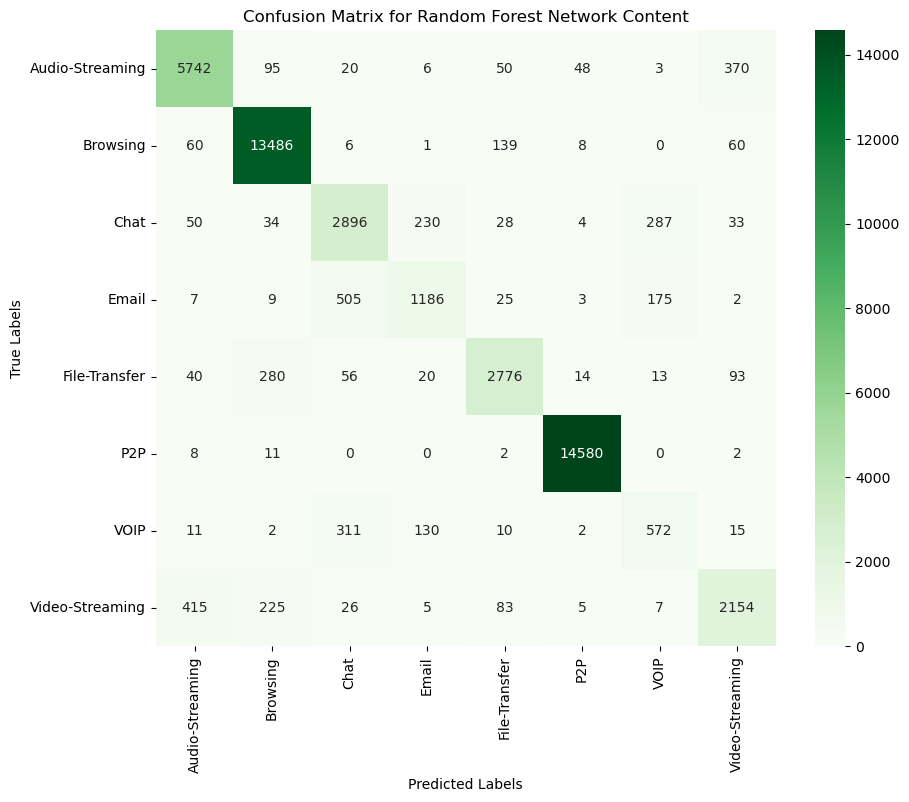

Classification Report for Random Forest Network Content:

                 precision    recall  f1-score   support

Audio-Streaming       0.91      0.91      0.91      6334
       Browsing       0.95      0.98      0.97     13760
           Chat       0.76      0.81      0.78      3562
          Email       0.75      0.62      0.68      1912
  File-Transfer       0.89      0.84      0.87      3292
            P2P       0.99      1.00      1.00     14603
           VOIP       0.54      0.54      0.54      1053
Video-Streaming       0.79      0.74      0.76      2920

       accuracy                           0.91     47436
      macro avg       0.82      0.81      0.81     47436
   weighted avg       0.91      0.91      0.91     47436





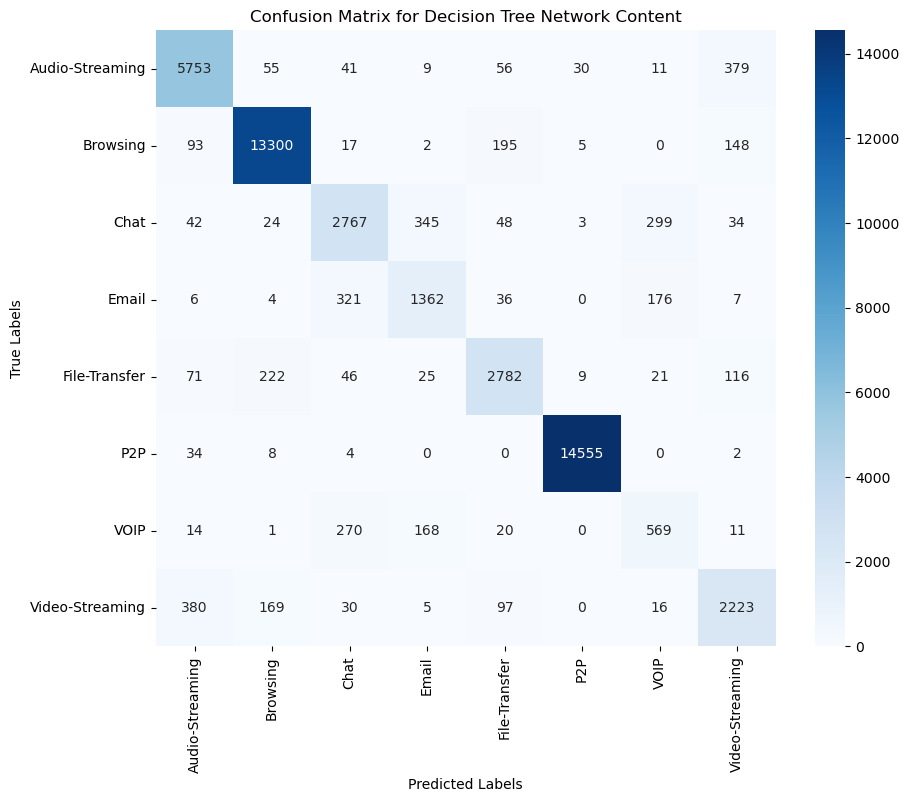

Classification Report for Decision Tree Network Content:

                 precision    recall  f1-score   support

Audio-Streaming       0.90      0.91      0.90      6334
       Browsing       0.96      0.97      0.97     13760
           Chat       0.79      0.78      0.78      3562
          Email       0.71      0.71      0.71      1912
  File-Transfer       0.86      0.85      0.85      3292
            P2P       1.00      1.00      1.00     14603
           VOIP       0.52      0.54      0.53      1053
Video-Streaming       0.76      0.76      0.76      2920

       accuracy                           0.91     47436
      macro avg       0.81      0.81      0.81     47436
   weighted avg       0.91      0.91      0.91     47436





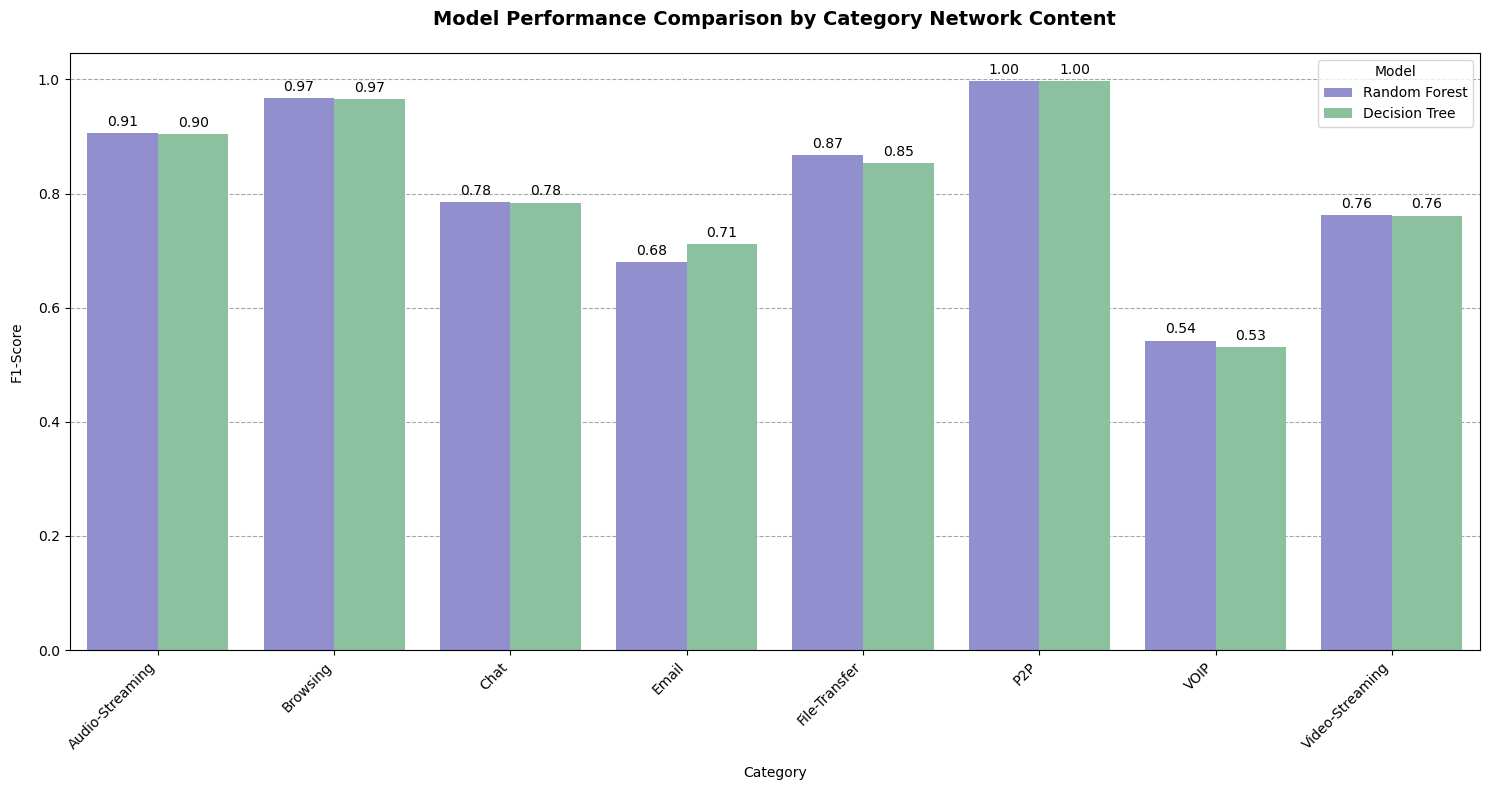


Detailed Performance Comparison:
                 Random Forest F1-Score  Decision Tree F1-Score  Difference
Audio-Streaming                   0.907                   0.904      -0.003
Browsing                          0.967                   0.966      -0.001
Chat                              0.785                   0.784      -0.001
Email                             0.680                   0.712       0.032
File-Transfer                     0.867                   0.853      -0.014
P2P                               0.996                   0.997       0.000
VOIP                              0.542                   0.531      -0.012
Video-Streaming                   0.763                   0.761      -0.001

Positive values in 'Difference' column indicate the second model performed better.


In [37]:

models_LabelOne = {
    "Random Forest": models_LabelOne["Random Forest"],
    "Decision Tree": models_LabelOne["Decision Tree"]
}


evaluate_and_compare_models(models_LabelOne,X_test,y_test_LabelOne,le_LabelOne,"Network Content")



In [38]:


numeric_df = df.select_dtypes(include=['number'])

X = numeric_df.drop(columns=['Label.1']) 
y = numeric_df['Label.1'] 


print("Total NaNs in X:", X.isnull().sum().sum())
print("Total infinite values in X:", np.isinf(X).sum().sum())
print("Total NaNs in y:", y.isnull().sum())
print("Total infinite values in y:", np.isinf(y).sum())

Total NaNs in X: 0
Total infinite values in X: 0
Total NaNs in y: 0
Total infinite values in y: 0


In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158117 entries, 0 to 158116
Data columns (total 68 columns):
 #   Column                      Non-Null Count   Dtype   
---  ------                      --------------   -----   
 0   Flow ID                     158117 non-null  category
 1   Src IP                      158117 non-null  category
 2   Src Port                    158117 non-null  float64 
 3   Dst IP                      158117 non-null  category
 4   Dst Port                    158117 non-null  float64 
 5   Protocol                    158117 non-null  float64 
 6   Timestamp                   158117 non-null  category
 7   Flow Duration               158117 non-null  float64 
 8   Total Fwd Packet            158117 non-null  float64 
 9   Total Bwd packets           158117 non-null  float64 
 10  Total Length of Fwd Packet  158117 non-null  float64 
 11  Total Length of Bwd Packet  158117 non-null  float64 
 12  Fwd Packet Length Max       158117 non-null  float64 
 13 

## Apply SMOTE for label 0

In [41]:
df = df.drop(columns=["Label.1"])# drop label 1 since we're manupilating label 0
df["Label"] = Label0

numeric_df = df.select_dtypes(include=['number'])
X = numeric_df.drop(columns=['Label'])  
y = numeric_df['Label']  


# apply SMOTE
smote_label0 = SMOTE(random_state=42)
X_resampled0, y_resampled0 = smote_label0.fit_resample(X, y) 

# split the resampled  into training and testing again always using 30% test size
X_train, X_test, y_train, y_test = train_test_split(X_resampled0, y_resampled0, test_size=0.3, random_state=42)


models_SMOTE_l0 = {
    "Logistic Regression": LogisticRegression(max_iter=10000, random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "K-Nearest Neighbors": KNeighborsClassifier(),
}


for model_name, model in models_SMOTE_l0.items():
    print(f"\nTraining and evaluating: {model_name}")
    model.fit(X_train, y_train)  
    y_pred = model.predict(X_test)  

 
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=le.classes_))


    print("\nConfusion Matrix:")
    conf_matrix = confusion_matrix(y_test, y_pred)
    print(conf_matrix)



Training and evaluating: Logistic Regression

Classification Report:
              precision    recall  f1-score   support

     Non-Tor       0.84      0.88      0.86     33043
      NonVPN       0.73      0.65      0.69     33252
         Tor       0.92      0.89      0.90     32899
         VPN       0.73      0.80      0.77     33152

    accuracy                           0.81    132346
   macro avg       0.81      0.81      0.80    132346
weighted avg       0.81      0.81      0.80    132346


Confusion Matrix:
[[28938  3641   247   217]
 [ 2778 21760  1703  7011]
 [  511   750 29232  2406]
 [ 2319  3641   583 26609]]

Training and evaluating: Random Forest

Classification Report:
              precision    recall  f1-score   support

     Non-Tor       1.00      1.00      1.00     33043
      NonVPN       0.96      0.98      0.97     33252
         Tor       1.00      1.00      1.00     32899
         VPN       0.99      0.96      0.97     33152

    accuracy                   

## show smote results for label 0


Evaluating model: Logistic Regression
Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.84      0.88      0.86     33043
           1       0.73      0.65      0.69     33252
           2       0.92      0.89      0.90     32899
           3       0.73      0.80      0.77     33152

    accuracy                           0.81    132346
   macro avg       0.81      0.81      0.80    132346
weighted avg       0.81      0.81      0.80    132346


Evaluating model: Random Forest
Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     33043
           1       0.96      0.98      0.97     33252
           2       1.00      1.00      1.00     32899
           3       0.99      0.96      0.97     33152

    accuracy                           0.99    132346
   macro avg       0.99      0.99      0.99    132346
weighted avg       0.99  

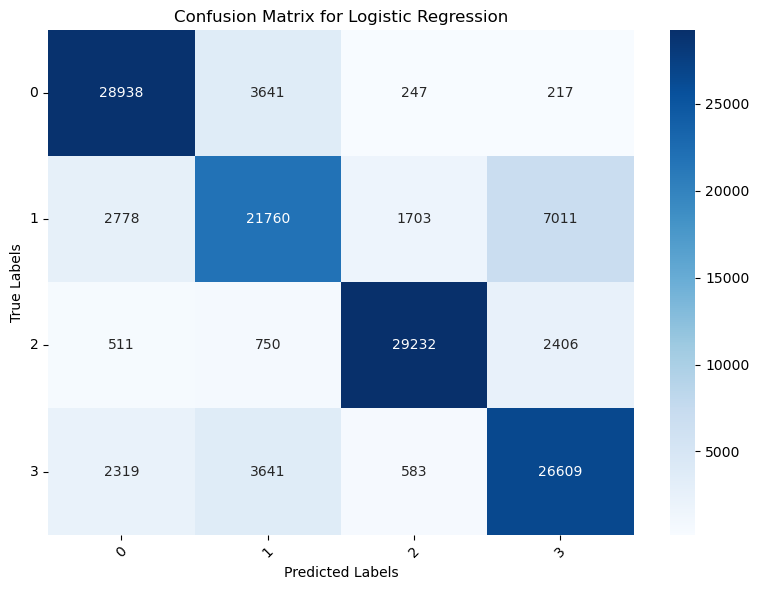

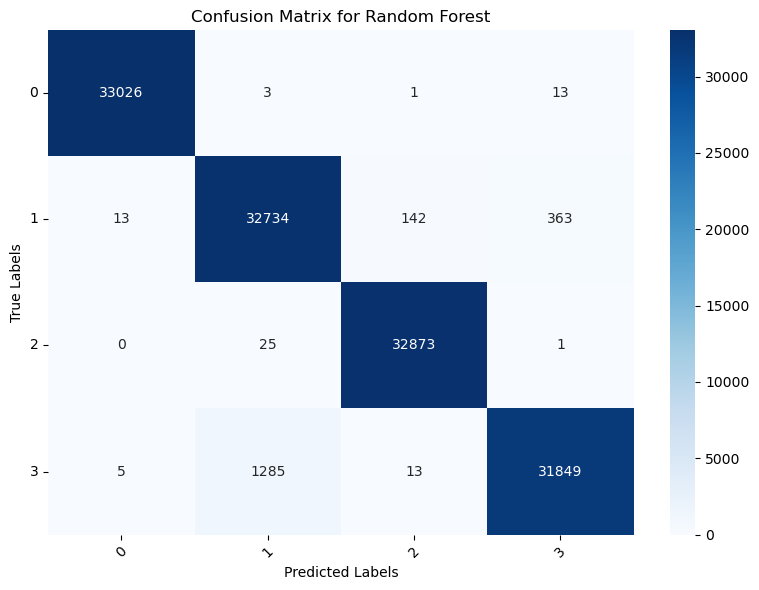

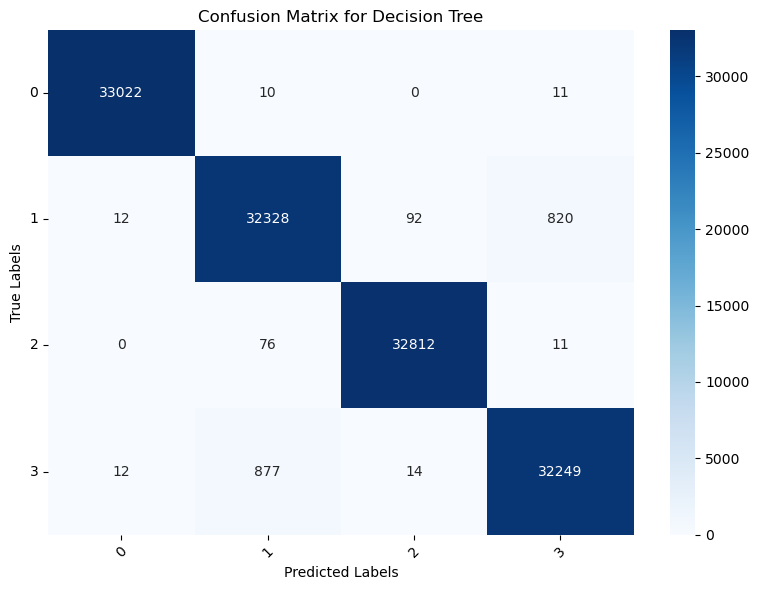

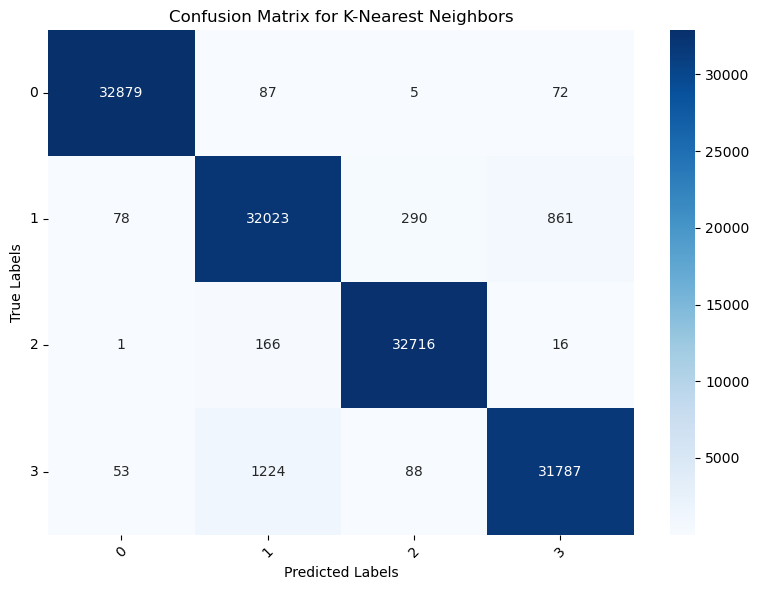

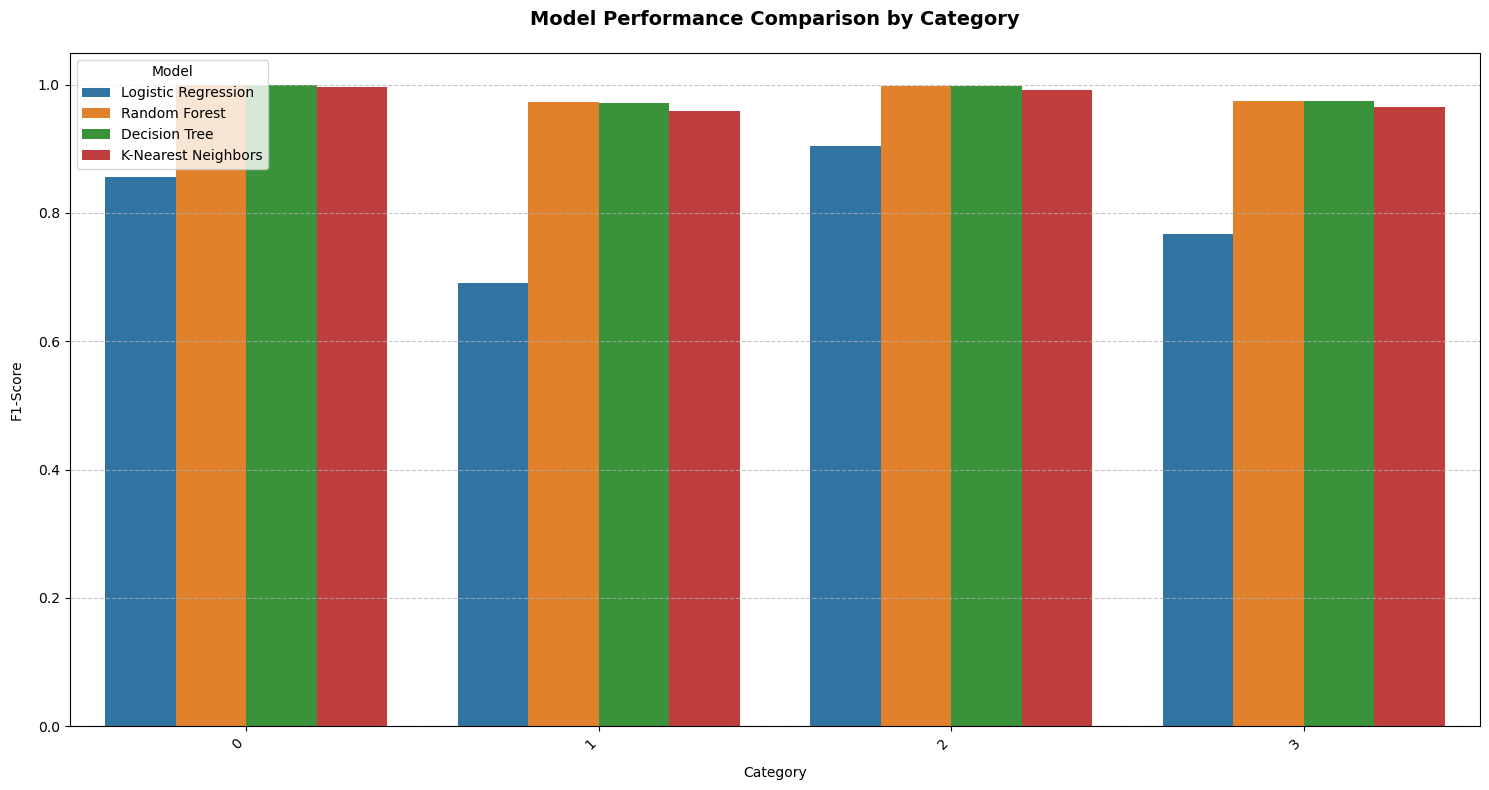


Detailed Performance Comparison (F1-Scores per Class):
   Logistic Regression  Random Forest  Decision Tree  K-Nearest Neighbors
0                0.856          0.999          0.999                0.996
1                0.690          0.973          0.972                0.959
2                0.904          0.997          0.997                0.991
3                0.767          0.974          0.974                0.965


In [43]:

model_names = ["Logistic Regression", "Random Forest", "Decision Tree", "K-Nearest Neighbors"]
models_trained = {name: models_SMOTE_l0[name] for name in model_names}


y_preds = {}
confusion_matrices = {}
classification_reports = {}
f1_scores_per_class = {}


classes = sorted(set(y_test))  
class_names = [str(cls) for cls in classes]  


for model_name, model in models_trained.items():
    print(f"\nEvaluating model: {model_name}")
    

    y_pred = model.predict(X_test)
    y_preds[model_name] = y_pred
    

    cm = confusion_matrix(y_test, y_pred, labels=classes)
    confusion_matrices[model_name] = cm
    

    report = classification_report(y_test, y_pred, target_names=class_names, zero_division=0)
    classification_reports[model_name] = report
    print(f"Classification Report for {model_name}:\n{report}")
    

    f1_scores = {}
    for cls in classes:
        f1 = f1_score(y_test == cls, y_pred == cls, zero_division=0)
        f1_scores[str(cls)] = f1
    f1_scores_per_class[model_name] = f1_scores


for model_name, cm in confusion_matrices.items():
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()


f1_scores_df = pd.DataFrame(f1_scores_per_class).reset_index()
f1_scores_df = f1_scores_df.melt(id_vars='index', var_name='Model', value_name='F1-Score')
f1_scores_df.rename(columns={'index': 'Category'}, inplace=True)


plt.figure(figsize=(15, 8))
sns.barplot(x='Category', y='F1-Score', hue='Model', data=f1_scores_df)
plt.title('Model Performance Comparison by Category', pad=20, size=14, fontweight='bold')
plt.xlabel('Category', labelpad=10)
plt.ylabel('F1-Score', labelpad=10)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Model')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


comparison_tables = {}
for cls in class_names:
    comparison_tables[cls] = {model_name: f1_scores_per_class[model_name][cls] for model_name in model_names}

comparison_df = pd.DataFrame(comparison_tables).T.round(3)
print("\nDetailed Performance Comparison (F1-Scores per Class):")
print(comparison_df)

## We can say much better results across classes, despite average accuracy styaing almost the same

In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158117 entries, 0 to 158116
Data columns (total 68 columns):
 #   Column                      Non-Null Count   Dtype   
---  ------                      --------------   -----   
 0   Flow ID                     158117 non-null  category
 1   Src IP                      158117 non-null  category
 2   Src Port                    158117 non-null  float64 
 3   Dst IP                      158117 non-null  category
 4   Dst Port                    158117 non-null  float64 
 5   Protocol                    158117 non-null  float64 
 6   Timestamp                   158117 non-null  category
 7   Flow Duration               158117 non-null  float64 
 8   Total Fwd Packet            158117 non-null  float64 
 9   Total Bwd packets           158117 non-null  float64 
 10  Total Length of Fwd Packet  158117 non-null  float64 
 11  Total Length of Bwd Packet  158117 non-null  float64 
 12  Fwd Packet Length Max       158117 non-null  float64 
 13 

## We have to do SMOTE for the Label 1

In [47]:

if "Label" in df.columns:
    df = df.drop(columns="Label")


df["Label.1"] = last_label
le_LabelOne = LabelEncoder()
df['Label.1'] = le_LabelOne.fit_transform(df['Label.1'])

numeric_df = df.select_dtypes(include=['number'])
X = numeric_df.drop(columns=['Label.1'])  
y = numeric_df['Label.1']  



smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)


X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)


models_SMOTE = {
    "Logistic Regression": LogisticRegression(max_iter=10000, random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "K-Nearest Neighbors": KNeighborsClassifier(),
}


for model_name, model in models_SMOTE.items():
    print(f"\nTraining and evaluating: {model_name}")
    model.fit(X_train, y_train)  
    y_pred = model.predict(X_test)  


    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=le_LabelOne.classes_))


    print("\nConfusion Matrix:")
    conf_matrix = confusion_matrix(y_test, y_pred)
    print(conf_matrix)




Training and evaluating: Logistic Regression

Classification Report:
                 precision    recall  f1-score   support

Audio-Streaming       0.51      0.58      0.54     14547
       Browsing       0.52      0.72      0.60     14508
           Chat       0.37      0.22      0.28     14631
          Email       0.47      0.24      0.32     14494
  File-Transfer       0.60      0.38      0.47     14362
            P2P       0.72      0.86      0.78     14463
           VOIP       0.45      0.80      0.58     14457
Video-Streaming       0.54      0.40      0.46     14526

       accuracy                           0.53    115988
      macro avg       0.52      0.53      0.50    115988
   weighted avg       0.52      0.53      0.50    115988


Confusion Matrix:
[[ 8454  1317   986   576   545   845   161  1663]
 [   25 10483  1071   272   810  1126   197   524]
 [ 2500   571  3253  1387   282   340  5736   562]
 [ 1055   864   603  3473   380   260  7480   379]
 [  919  3089   966 


Evaluating model: Logistic Regression
Classification Report for Logistic Regression:
                 precision    recall  f1-score   support

Audio-Streaming       0.51      0.58      0.54     14547
       Browsing       0.52      0.72      0.60     14508
           Chat       0.37      0.22      0.28     14631
          Email       0.47      0.24      0.32     14494
  File-Transfer       0.60      0.38      0.47     14362
            P2P       0.72      0.86      0.78     14463
           VOIP       0.45      0.80      0.58     14457
Video-Streaming       0.54      0.40      0.46     14526

       accuracy                           0.53    115988
      macro avg       0.52      0.53      0.50    115988
   weighted avg       0.52      0.53      0.50    115988


Evaluating model: Random Forest
Classification Report for Random Forest:
                 precision    recall  f1-score   support

Audio-Streaming       0.95      0.89      0.92     14547
       Browsing       0.94      0.97  

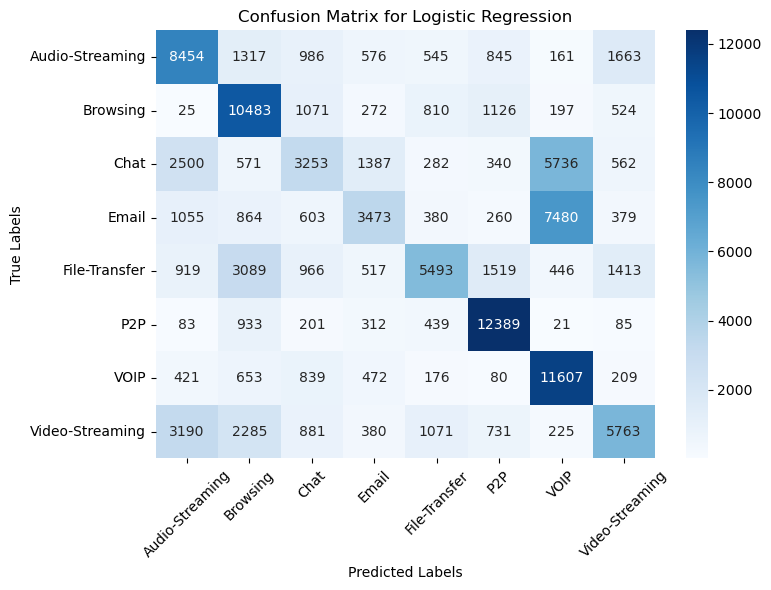

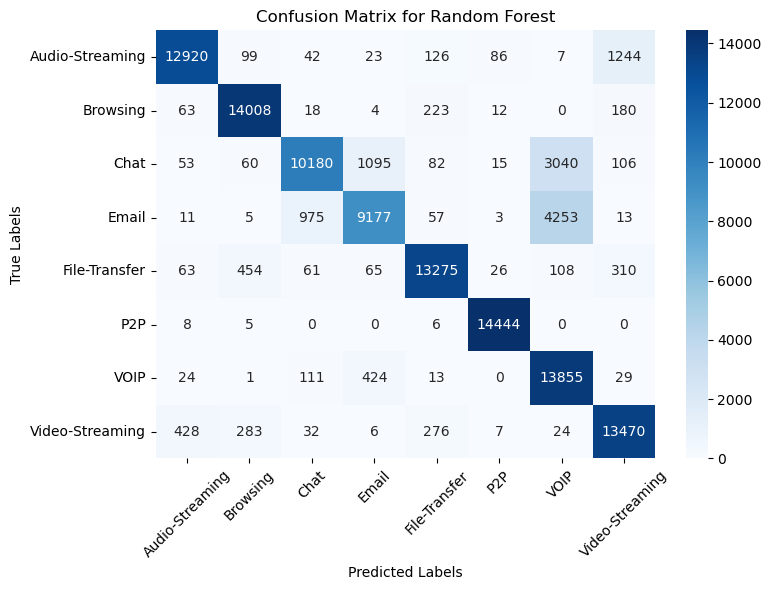

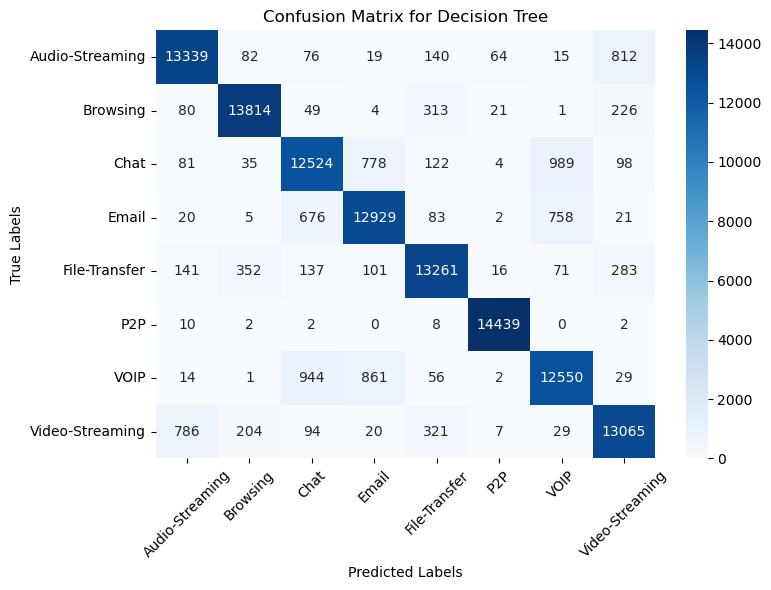

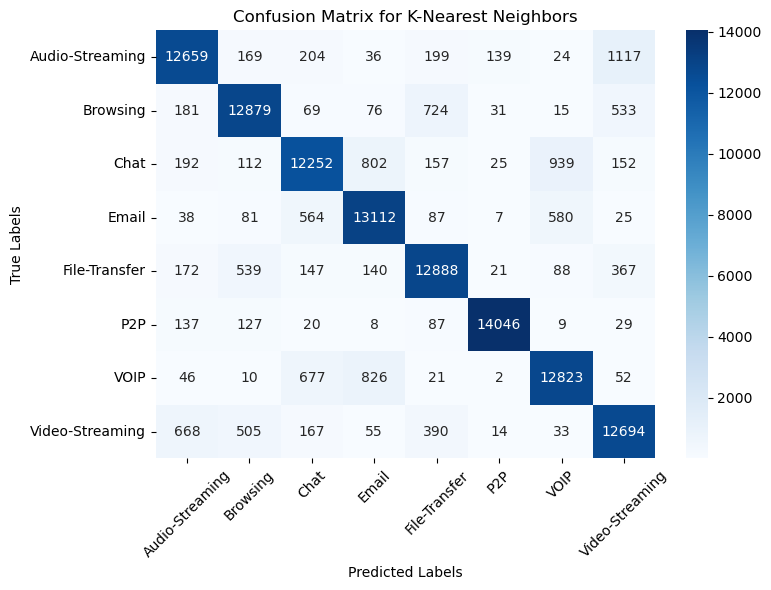

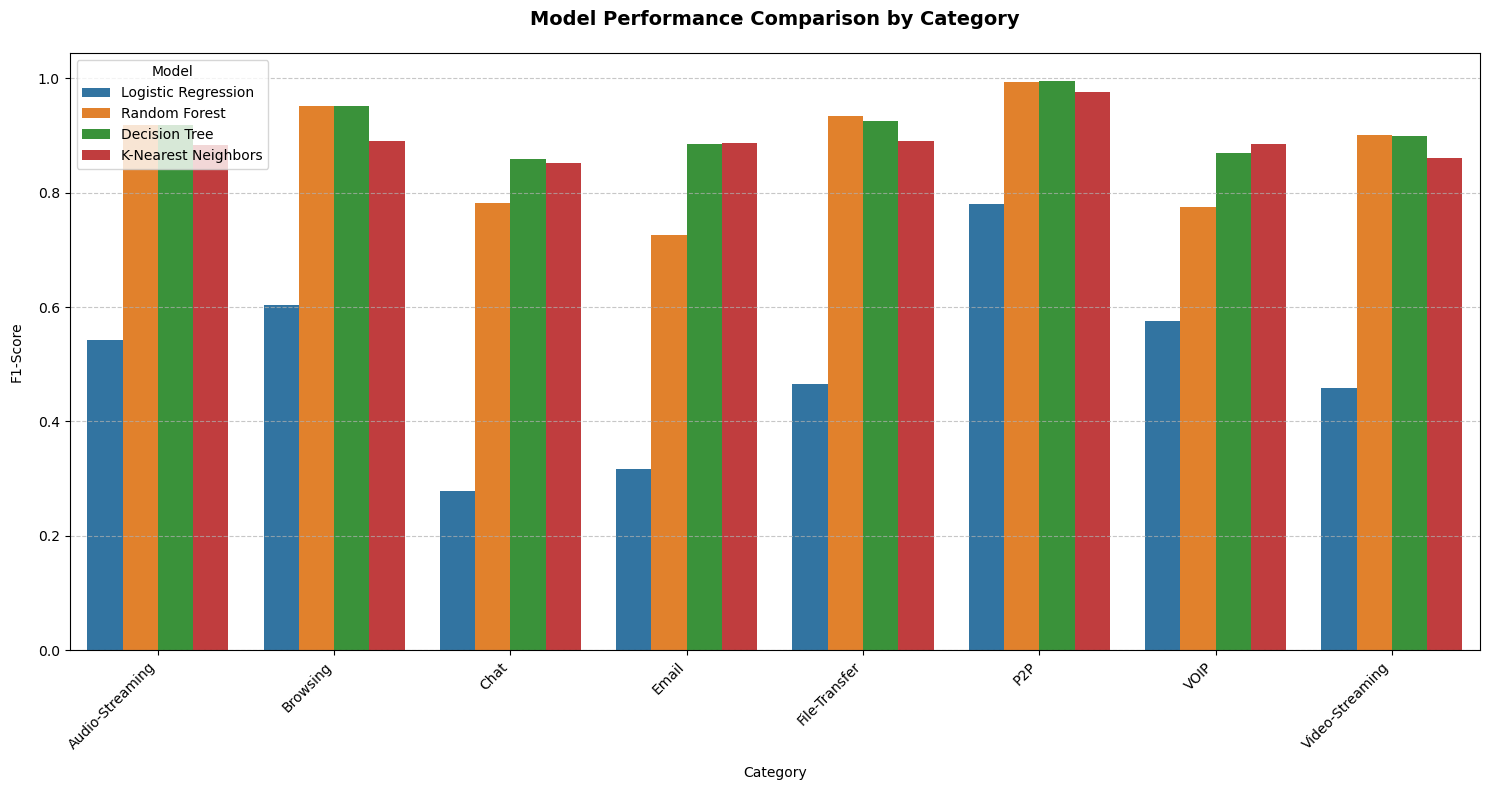


Detailed Performance Comparison (F1-Scores per Class):
                 Logistic Regression  Random Forest  Decision Tree  \
Audio-Streaming                0.542          0.919          0.919   
Browsing                       0.604          0.952          0.953   
Chat                           0.278          0.782          0.860   
Email                          0.317          0.726          0.885   
File-Transfer                  0.466          0.934          0.925   
P2P                            0.780          0.994          0.995   
VOIP                           0.576          0.775          0.869   
Video-Streaming                0.459          0.902          0.899   

                 K-Nearest Neighbors  
Audio-Streaming                0.884  
Browsing                       0.890  
Chat                           0.853  
Email                          0.887  
File-Transfer                  0.891  
P2P                            0.977  
VOIP                           0.885  
V

In [48]:

model_names = ["Logistic Regression", "Random Forest", "Decision Tree", "K-Nearest Neighbors"]
models_trained = {name: models_SMOTE[name] for name in model_names}


y_preds = {}
confusion_matrices = {}
classification_reports = {}
f1_scores_per_class = {}


class_names = le_LabelOne.classes_  


for model_name, model in models_trained.items():
    print(f"\nEvaluating model: {model_name}")
    

    y_pred = model.predict(X_test)
    y_preds[model_name] = y_pred
    

    cm = confusion_matrix(y_test, y_pred, labels=range(len(class_names)))
    confusion_matrices[model_name] = cm
    

    report = classification_report(y_test, y_pred, target_names=class_names, zero_division=0)
    classification_reports[model_name] = report
    print(f"Classification Report for {model_name}:\n{report}")
    

    f1_scores = {}
    for i, cls_name in enumerate(class_names):
        f1 = f1_score(y_test == i, y_pred == i, zero_division=0)
        f1_scores[cls_name] = f1
    f1_scores_per_class[model_name] = f1_scores


for model_name, cm in confusion_matrices.items():
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()


f1_scores_df = pd.DataFrame(f1_scores_per_class).reset_index()
f1_scores_df = f1_scores_df.melt(id_vars='index', var_name='Model', value_name='F1-Score')
f1_scores_df.rename(columns={'index': 'Category'}, inplace=True)


plt.figure(figsize=(15, 8))
sns.barplot(x='Category', y='F1-Score', hue='Model', data=f1_scores_df)
plt.title('Model Performance Comparison by Category', pad=20, size=14, fontweight='bold')
plt.xlabel('Category', labelpad=10)
plt.ylabel('F1-Score', labelpad=10)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Model')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


comparison_tables = {}
for cls in class_names:
    comparison_tables[cls] = {model_name: f1_scores_per_class[model_name][cls] for model_name in model_names}
comparison_df = pd.DataFrame(comparison_tables).T.round(3)
print("\nDetailed Performance Comparison (F1-Scores per Class):")
print(comparison_df)

## Feature Selection For Label 1

In [50]:


numeric_df = df.select_dtypes(include=['number'])


X = numeric_df.drop(columns=['Label.1'])  
y = numeric_df['Label.1'] 


X.replace([np.inf, -np.inf], np.nan, inplace=True)
X.dropna(inplace=True)
y = y.loc[X.index]


X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)


base_model = DecisionTreeClassifier()

# forward selection
sfs = SequentialFeatureSelector(
    base_model,
    n_features_to_select=10,
    direction='forward',
    scoring='accuracy',
    cv=5,  # 5fold cross validation
    n_jobs=-1
)


sfs.fit(X_train_full, y_train_full)


selected_features = X_train_full.columns[sfs.get_support()]

print("Selected features:", selected_features)


X_train = sfs.transform(X_train_full)
X_test_selected = sfs.transform(X_test)

# Now, retrain model with selected features to see if any model does better than trees

models = {
    "Logistic Regression": LogisticRegression(max_iter=10000),
    "Random Forest": RandomForestClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "K-Nearest Neighbors": KNeighborsClassifier(),
}


results = []
for model_name, model in models.items():
    model.fit(X_train, y_train_full)  
    y_pred = model.predict(X_test_selected)  


    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

    results.append(
        {
            "Model": model_name,
            "Accuracy": accuracy,
            "Precision": precision,
            "Recall": recall,
            "F1 Score": f1,
        }
    )


results_df = pd.DataFrame(results)
print(results_df)


Selected features: Index(['Src Port', 'Dst Port', 'Flow Duration', 'Fwd Packet Length Max',
       'Bwd Packet Length Min', 'Bwd Header Length', 'Packet Length Mean',
       'FWD Init Win Bytes', 'Bwd Init Win Bytes', 'Idle Max'],
      dtype='object')
                 Model  Accuracy  Precision    Recall  F1 Score
0  Logistic Regression  0.547791   0.519724  0.547791  0.483137
1        Random Forest  0.927692   0.926576  0.927692  0.926979
2        Decision Tree  0.919428   0.919137  0.919428  0.919256
3  K-Nearest Neighbors  0.828464   0.819599  0.828464  0.820719


## Feature selection for Label 0

In [52]:
df["Label"] = Label0
df = df.drop(columns="Label.1") # drop label 1 since we're feature selecting for label 0

In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158117 entries, 0 to 158116
Data columns (total 68 columns):
 #   Column                      Non-Null Count   Dtype   
---  ------                      --------------   -----   
 0   Flow ID                     158117 non-null  category
 1   Src IP                      158117 non-null  category
 2   Src Port                    158117 non-null  float64 
 3   Dst IP                      158117 non-null  category
 4   Dst Port                    158117 non-null  float64 
 5   Protocol                    158117 non-null  float64 
 6   Timestamp                   158117 non-null  category
 7   Flow Duration               158117 non-null  float64 
 8   Total Fwd Packet            158117 non-null  float64 
 9   Total Bwd packets           158117 non-null  float64 
 10  Total Length of Fwd Packet  158117 non-null  float64 
 11  Total Length of Bwd Packet  158117 non-null  float64 
 12  Fwd Packet Length Max       158117 non-null  float64 
 13 

## Feature Selection and Grid Search for Label 0 ( Network protocol)

In [55]:

numeric_df = df.select_dtypes(include=['number'])


X = numeric_df.drop(columns=['Label']) 
y = numeric_df['Label']  



X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)


base_model = DecisionTreeClassifier()

# Apply forward selection
sfs = SequentialFeatureSelector(
    base_model,
    n_features_to_select=10,  
    direction='forward',
    scoring='accuracy',
    cv=5,  
    n_jobs=-1
)


sfs.fit(X_train_full, y_train_full)


selected_features = X_train_full.columns[sfs.get_support()]

print("Selected features:", selected_features)


X_train = sfs.transform(X_train_full)
X_test_selected = sfs.transform(X_test)


models = {
    "Logistic Regression": LogisticRegression(max_iter=10000),
    "Random Forest": RandomForestClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "K-Nearest Neighbors": KNeighborsClassifier(),
}


results = []
for model_name, model in models.items():
    model.fit(X_train, y_train_full)  
    y_pred = model.predict(X_test_selected)  


    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)


    results.append(
        {
            "Model": model_name,
            "Accuracy": accuracy,
            "Precision": precision,
            "Recall": recall,
            "F1 Score": f1,
        }
    )


results_df = pd.DataFrame(results)
print(results_df)


Selected features: Index(['Dst Port', 'Fwd Packet Length Max', 'Fwd Packets/s', 'Bwd Packets/s',
       'Packet Length Max', 'SYN Flag Count', 'FWD Init Win Bytes',
       'Bwd Init Win Bytes', 'Fwd Seg Size Min', 'Idle Max'],
      dtype='object')
                 Model  Accuracy  Precision    Recall  F1 Score
0  Logistic Regression  0.717683   0.587636  0.717683  0.638763
1        Random Forest  0.986782   0.986860  0.986782  0.986767
2        Decision Tree  0.984252   0.984297  0.984252  0.984240
3  K-Nearest Neighbors  0.974618   0.974516  0.974618  0.974554


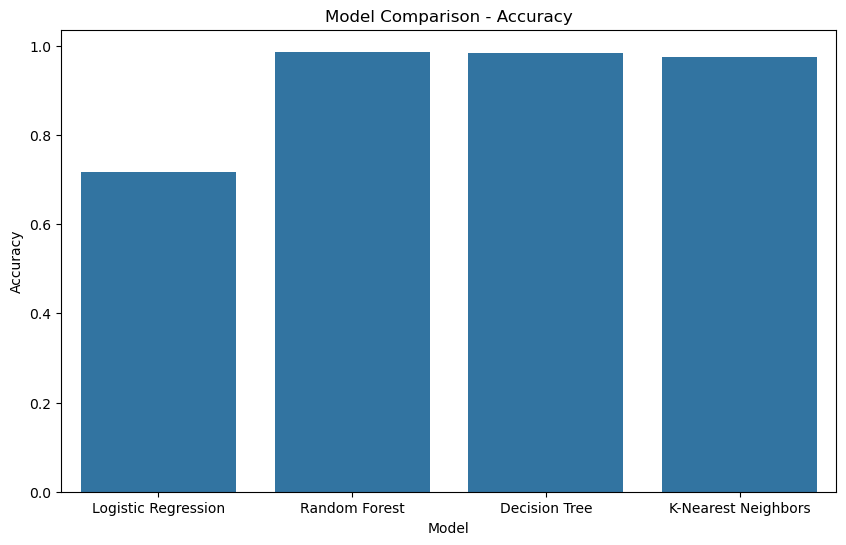

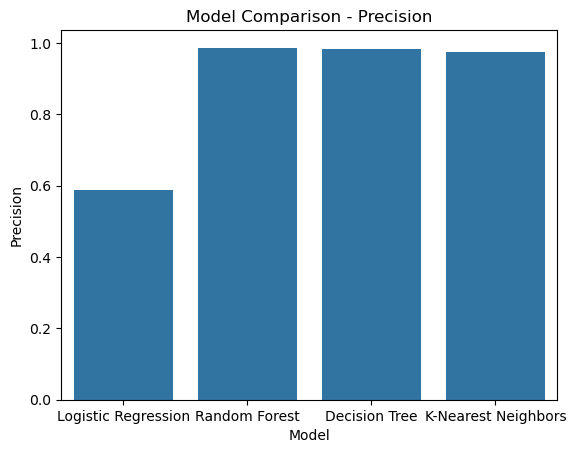

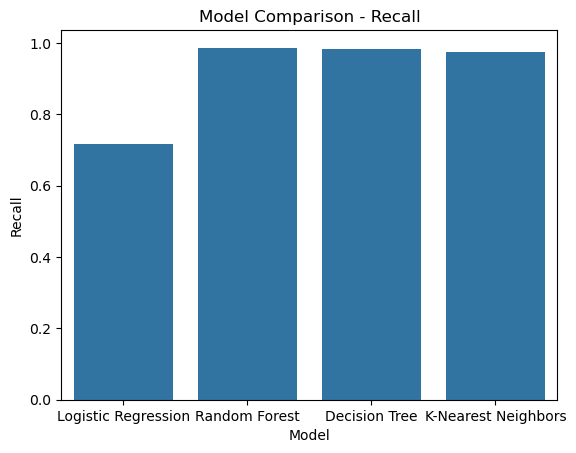

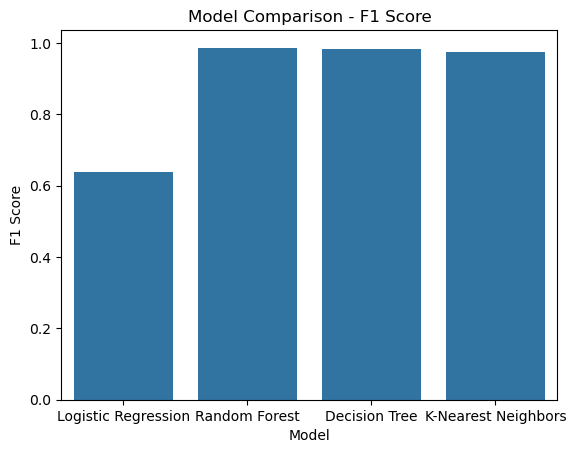


Classification Report for Decision Tree:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     33042
           1       0.94      0.94      0.94      7196
           2       0.89      0.91      0.90       327
           3       0.95      0.94      0.94      6871

    accuracy                           0.98     47436
   macro avg       0.94      0.95      0.95     47436
weighted avg       0.98      0.98      0.98     47436



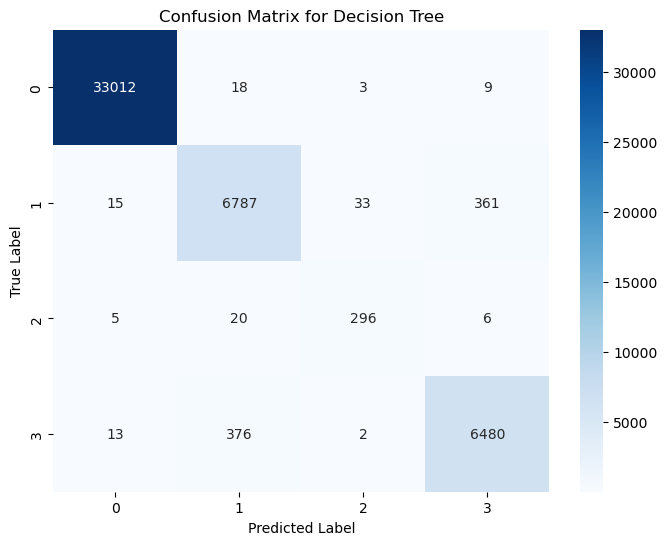


Feature Importances:
FWD Init Win Bytes       0.278481
Idle Max                 0.271517
Dst Port                 0.109677
Packet Length Max        0.092664
Fwd Seg Size Min         0.087434
Bwd Packets/s            0.075564
Fwd Packet Length Max    0.037948
Fwd Packets/s            0.034847
Bwd Init Win Bytes       0.011720
SYN Flag Count           0.000147
dtype: float64


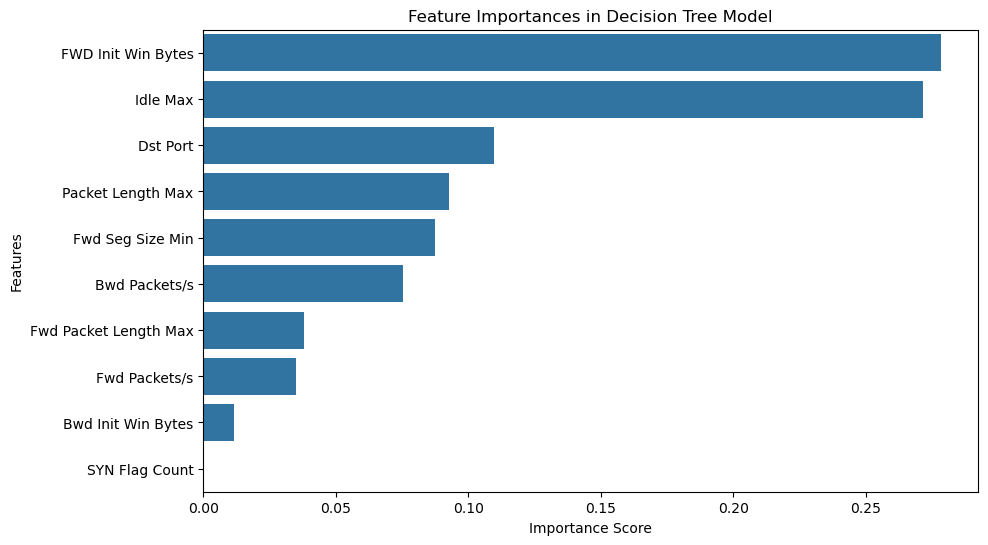

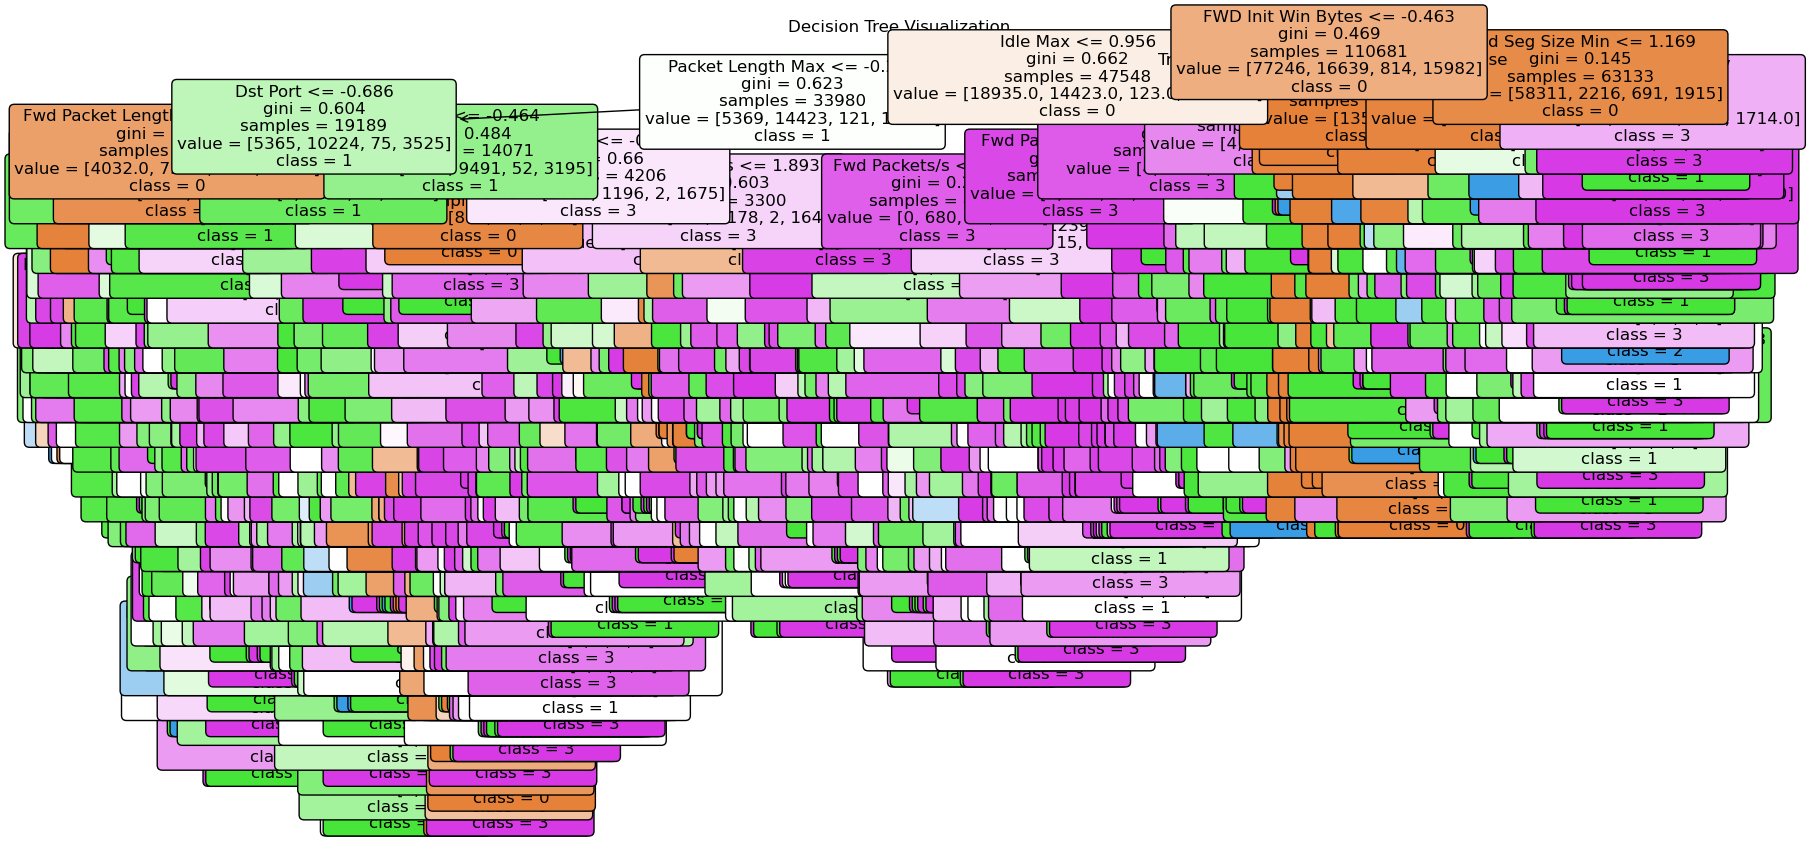


Cross-Validation Scores: [0.98595112 0.98247199 0.98459523 0.98495663 0.98400795]
Mean Cross-Validation Score: 0.9844

Best Parameters from Grid Search: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}

Classification Report for Tuned Decision Tree:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     33042
           1       0.94      0.96      0.95      7196
           2       0.92      0.88      0.90       327
           3       0.96      0.94      0.95      6871

    accuracy                           0.98     47436
   macro avg       0.95      0.95      0.95     47436
weighted avg       0.98      0.98      0.98     47436



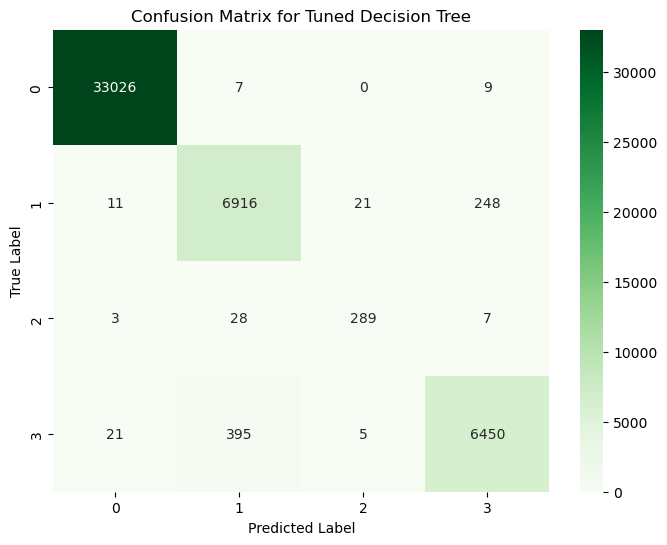


Feature Importances for Tuned Model:
FWD Init Win Bytes       0.278281
Idle Max                 0.271070
Dst Port                 0.109653
Packet Length Max        0.092817
Fwd Seg Size Min         0.087497
Bwd Packets/s            0.077619
Fwd Packet Length Max    0.038461
Fwd Packets/s            0.032967
Bwd Init Win Bytes       0.011518
SYN Flag Count           0.000117
dtype: float64


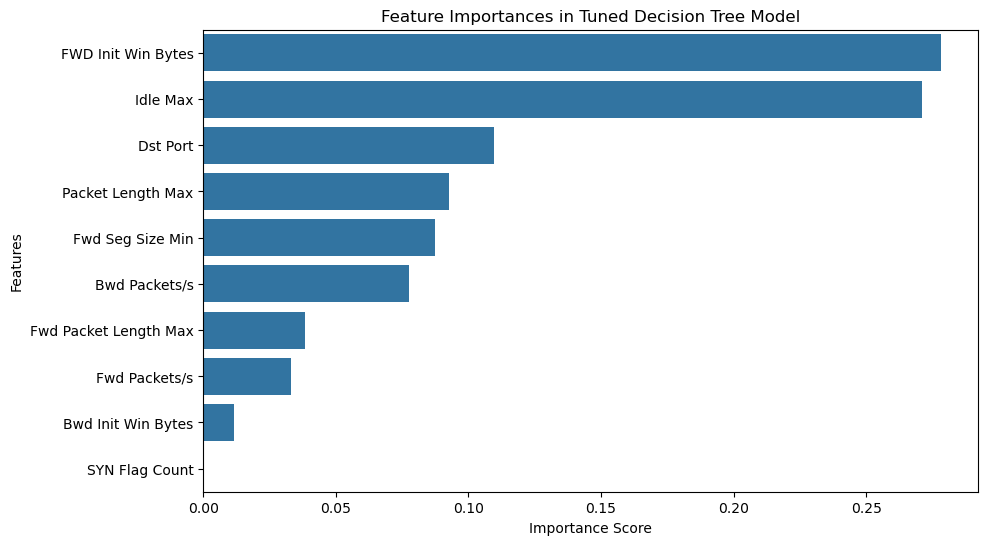

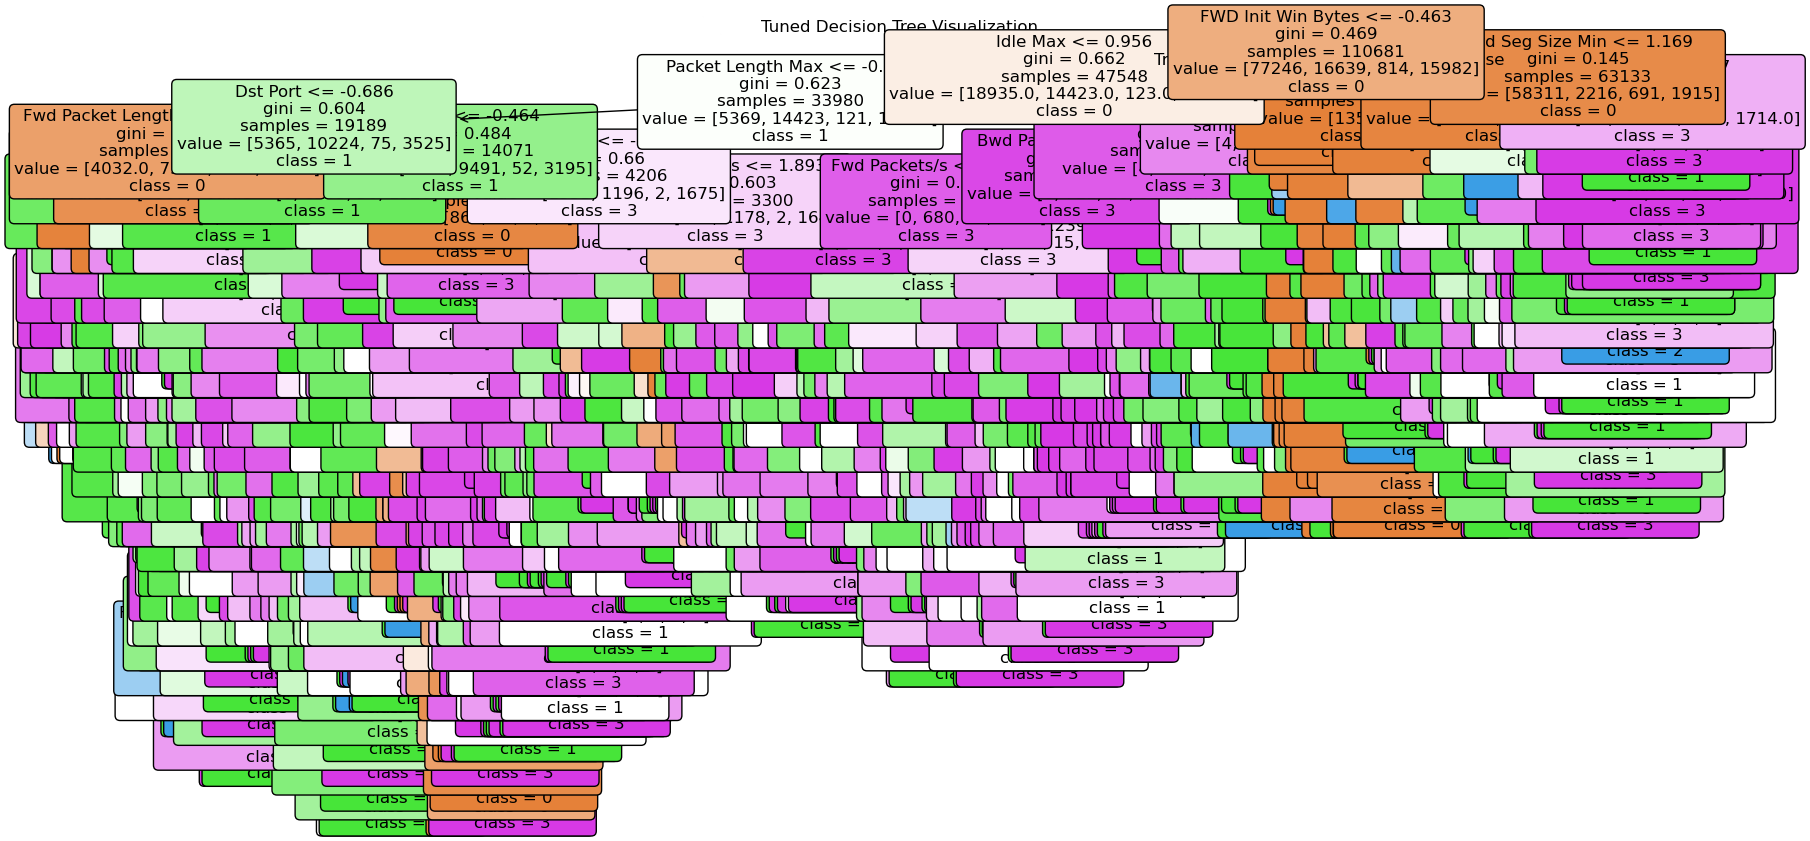

In [56]:


plt.figure(figsize=(10, 6))
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
for metric in metrics:
    sns.barplot(x='Model', y=metric, data=results_df)
    plt.title(f'Model Comparison - {metric}')
    plt.ylabel(metric)
    plt.xlabel('Model')
    plt.show()


dt_model = models['Decision Tree']
y_pred_dt = model_predictions['Decision Tree']


print("\nClassification Report for Decision Tree:")
print(classification_report(y_test, y_pred_dt))


cm = confusion_matrix(y_test, y_pred_dt)
cm_df = pd.DataFrame(cm, index=np.unique(y), columns=np.unique(y))

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for Decision Tree')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


feature_importances = pd.Series(dt_model.feature_importances_, index=selected_features)
feature_importances.sort_values(ascending=False, inplace=True)

print("\nFeature Importances:")
print(feature_importances)

# Visualize Feature Importances
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances, y=feature_importances.index)
plt.title('Feature Importances in Decision Tree Model')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()


plt.figure(figsize=(20, 10))
plot_tree(
    dt_model,
    feature_names=selected_features,
    class_names=dt_model.classes_.astype(str),
    filled=True,
    rounded=True,
    fontsize=12,
)
plt.title('Decision Tree Visualization')
plt.show()


cv_scores = cross_val_score(dt_model, X_train, y_train_full, cv=5, scoring='accuracy')
print(f"\nCross-Validation Scores: {cv_scores}")
print(f"Mean Cross-Validation Score: {cv_scores.mean():.4f}")

# Hyperparameter Tuning using Grid search
param_grid = {
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 5, 10],
    'criterion': ['gini', 'entropy']
}

grid_search = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)
grid_search.fit(X_train, y_train_full)

print(f"\nBest Parameters from Grid Search: {grid_search.best_params_}")
best_dt_model = grid_search.best_estimator_

# Evaluate the Tuned Model
y_pred_tuned = best_dt_model.predict(X_test_selected)
print("\nClassification Report for Tuned Decision Tree:")
print(classification_report(y_test, y_pred_tuned))


cm_tuned = confusion_matrix(y_test, y_pred_tuned)
cm_tuned_df = pd.DataFrame(cm_tuned, index=np.unique(y), columns=np.unique(y))


plt.figure(figsize=(8, 6))
sns.heatmap(cm_tuned_df, annot=True, fmt='d', cmap='Greens')
plt.title('Confusion Matrix for Tuned Decision Tree')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


feature_importances_tuned = pd.Series(best_dt_model.feature_importances_, index=selected_features)
feature_importances_tuned.sort_values(ascending=False, inplace=True)

print("\nFeature Importances for Tuned Model:")
print(feature_importances_tuned)

# Visualize Feature Importances for Tuned Model
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances_tuned, y=feature_importances_tuned.index)
plt.title('Feature Importances in Tuned Decision Tree Model')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()


plt.figure(figsize=(20, 10))
plot_tree(
    best_dt_model,
    feature_names=selected_features,
    class_names=best_dt_model.classes_.astype(str),
    filled=True,
    rounded=True,
    fontsize=12,
)
plt.title('Tuned Decision Tree Visualization')
plt.show()

## Putting it all together  For Label 0

Selected features: Index(['Dst Port', 'Fwd Packet Length Max', 'Fwd Packets/s', 'Bwd Packets/s',
       'Packet Length Max', 'Subflow Fwd Packets', 'FWD Init Win Bytes',
       'Bwd Init Win Bytes', 'Fwd Seg Size Min', 'Idle Max'],
      dtype='object')

Model Performance Metrics:
           Model  Accuracy  Precision    Recall  F1 Score
0  Decision Tree  0.984168   0.984221  0.984168  0.984152

Classification Report for Decision Tree:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     33042
           1       0.94      0.96      0.95      7196
           2       0.92      0.88      0.90       327
           3       0.96      0.94      0.95      6871

    accuracy                           0.98     47436
   macro avg       0.96      0.95      0.95     47436
weighted avg       0.98      0.98      0.98     47436



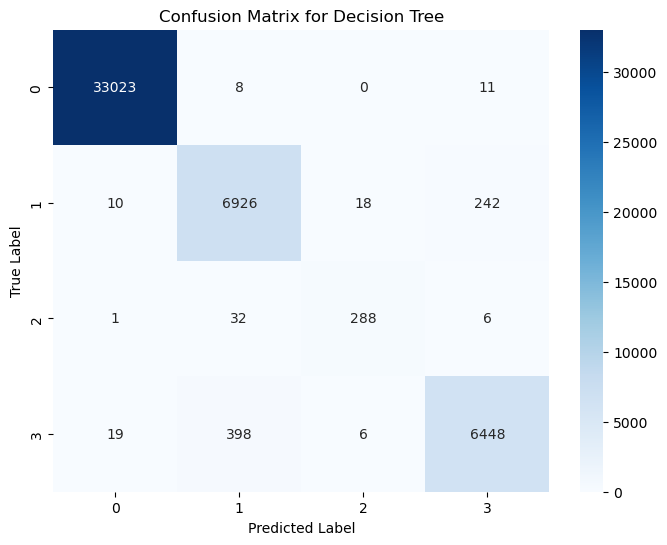


Feature Importances:
FWD Init Win Bytes       0.277747
Idle Max                 0.271218
Dst Port                 0.109353
Packet Length Max        0.091930
Fwd Seg Size Min         0.087793
Bwd Packets/s            0.079355
Fwd Packet Length Max    0.039034
Fwd Packets/s            0.031205
Bwd Init Win Bytes       0.011485
Subflow Fwd Packets      0.000881
dtype: float64


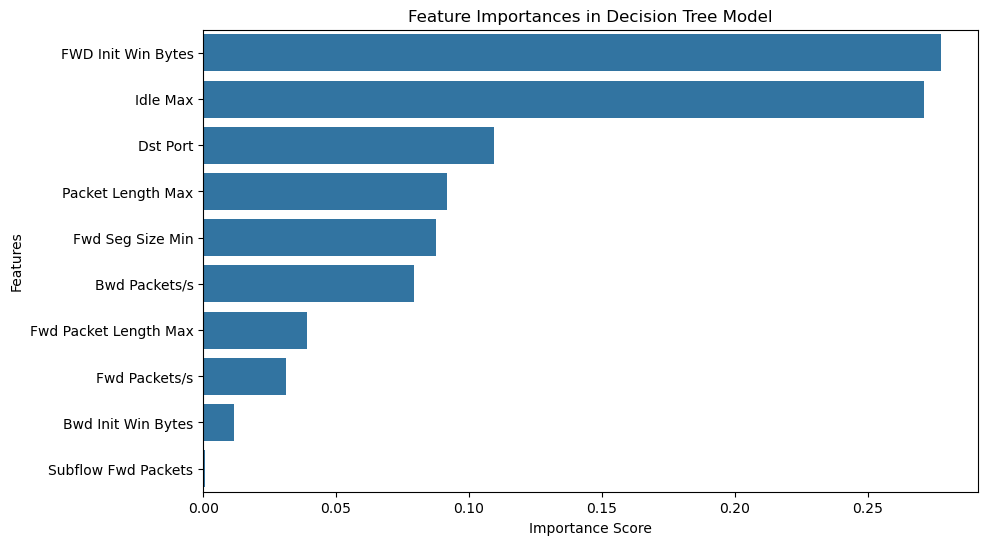

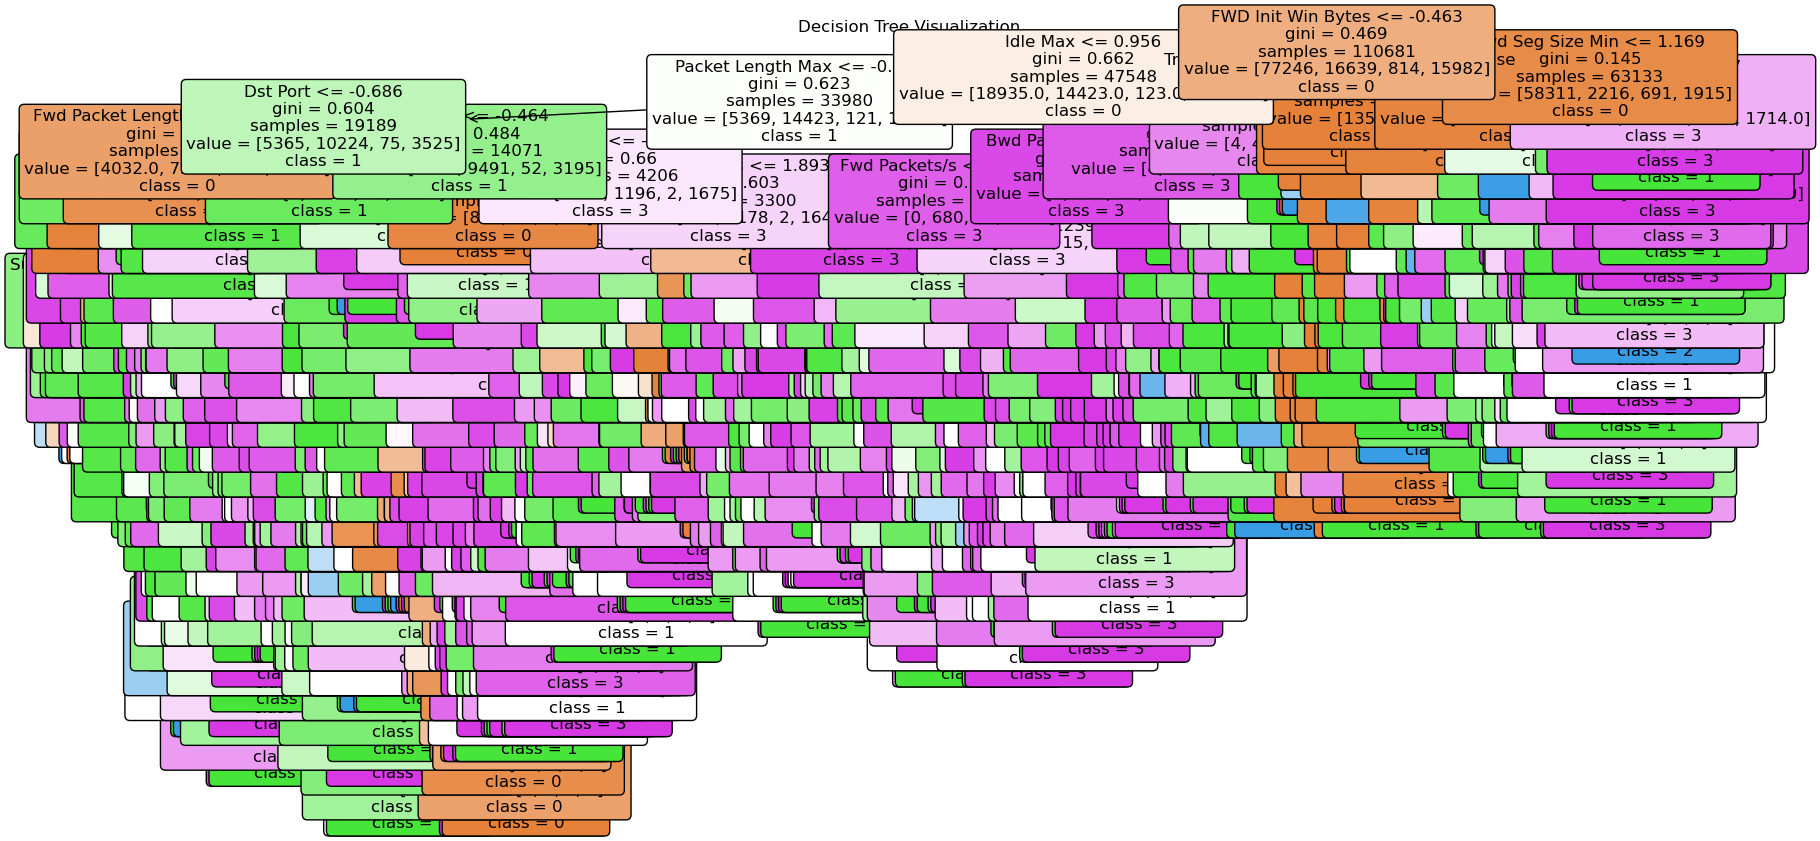


Cross-Validation Scores: [0.9859963  0.98220094 0.98473076 0.98504698 0.98455005]
Mean Cross-Validation Score: 0.9845

Best Parameters from Grid Search: {'criterion': 'gini', 'max_depth': None, 'min_samples_split': 2}

Classification Report for Tuned Decision Tree:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     33042
           1       0.94      0.96      0.95      7196
           2       0.92      0.88      0.90       327
           3       0.96      0.94      0.95      6871

    accuracy                           0.98     47436
   macro avg       0.96      0.95      0.95     47436
weighted avg       0.98      0.98      0.98     47436



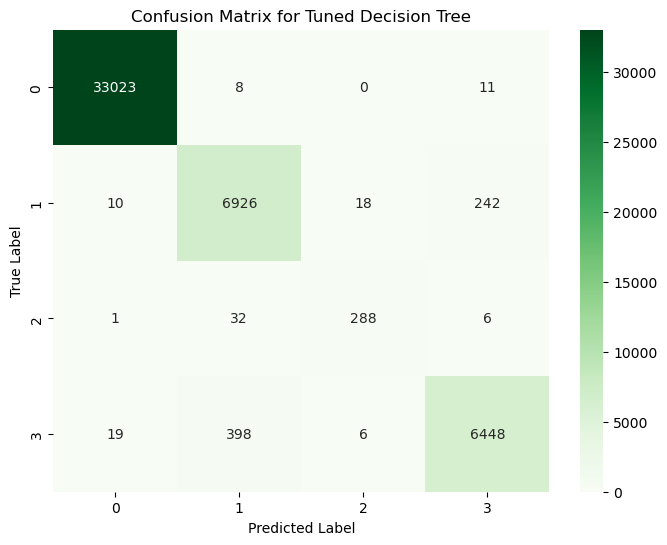


Feature Importances for Tuned Model:
FWD Init Win Bytes       0.277747
Idle Max                 0.271218
Dst Port                 0.109353
Packet Length Max        0.091930
Fwd Seg Size Min         0.087793
Bwd Packets/s            0.079355
Fwd Packet Length Max    0.039034
Fwd Packets/s            0.031205
Bwd Init Win Bytes       0.011485
Subflow Fwd Packets      0.000881
dtype: float64


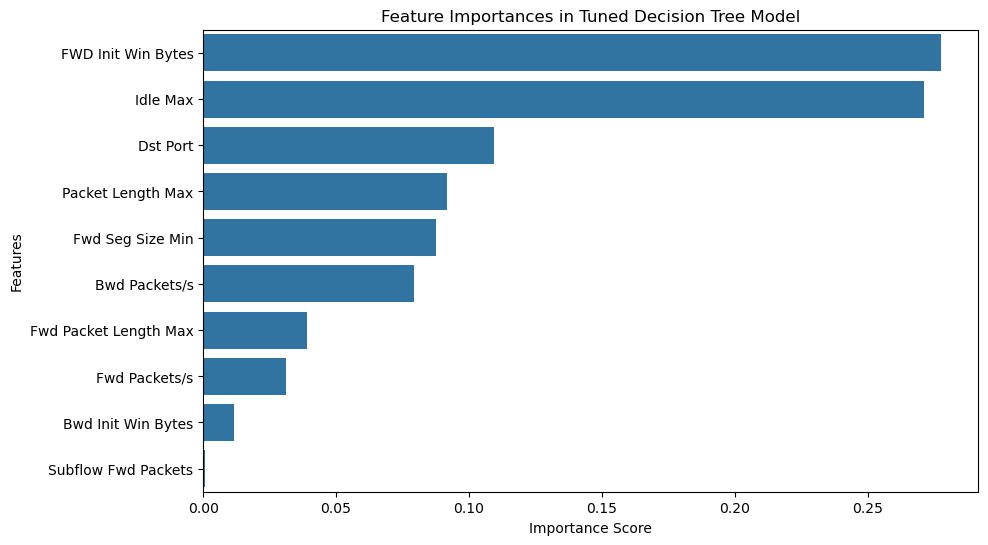

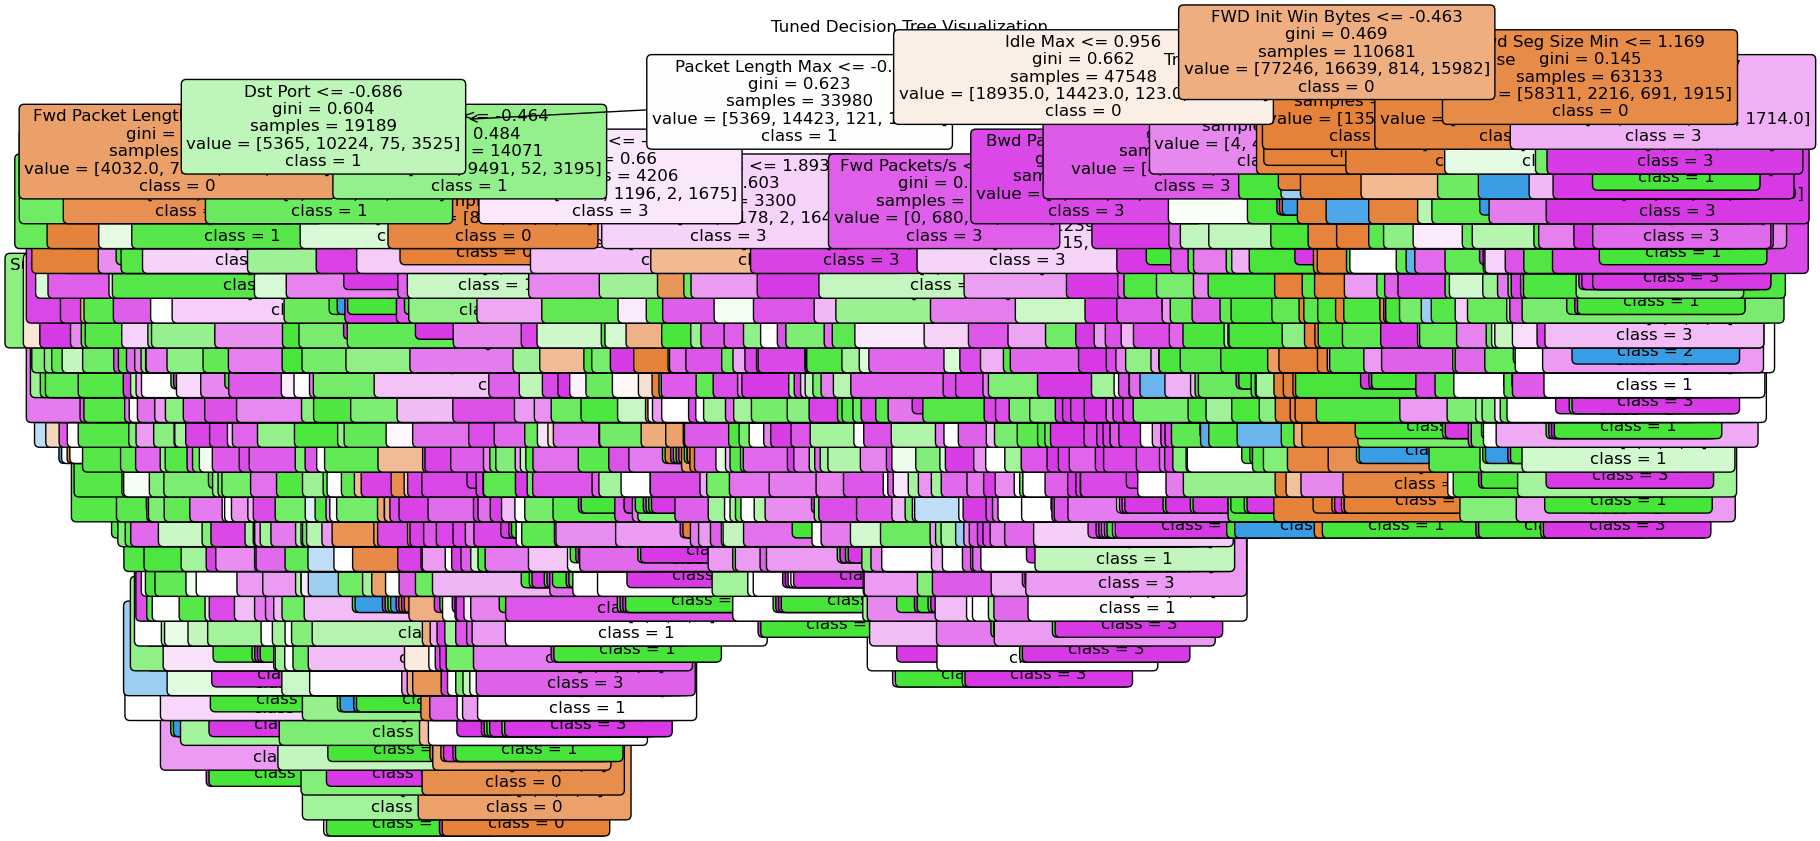

In [58]:

numeric_df = df.select_dtypes(include=['number'])

# just sanity check
if "Label.1" in numeric_df.columns:
    numeric_df = numeric_df.drop(columns="Label.1")
    
if 'Label' in numeric_df.columns:
    target_column = 'Label'
else:
    raise ValueError("Target column 'Label' or 'Label' not found in the dataset.")


X = numeric_df.drop(columns=[target_column])  
y = numeric_df[target_column]  


X.replace([np.inf, -np.inf], np.nan, inplace=True)
X.dropna(inplace=True)
y = y.loc[X.index]


X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)


base_model = DecisionTreeClassifier(random_state=42)


sfs = SequentialFeatureSelector(
    base_model,
    n_features_to_select=10, 
    direction='forward',
    scoring='accuracy',
    cv=5,
    n_jobs=-1 # use full cpu
)

sfs.fit(X_train_full, y_train_full)


selected_features = X_train_full.columns[sfs.get_support()]

print("Selected features:", selected_features)


X_train = sfs.transform(X_train_full)
X_test_selected = sfs.transform(X_test)


models = {
    "Decision Tree": DecisionTreeClassifier(random_state=42),
  
}


results = []
model_predictions = {}
for model_name, model in models.items():
    model.fit(X_train, y_train_full)
    y_pred = model.predict(X_test_selected) 
    model_predictions[model_name] = y_pred  


    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)


    results.append(
        {
            "Model": model_name,
            "Accuracy": accuracy,
            "Precision": precision,
            "Recall": recall,
            "F1 Score": f1,
        }
    )


results_df = pd.DataFrame(results)
print("\nModel Performance Metrics:")
print(results_df)


dt_model = models['Decision Tree']
y_pred_dt = model_predictions['Decision Tree']


print("\nClassification Report for Decision Tree:")
print(classification_report(y_test, y_pred_dt))


cm = confusion_matrix(y_test, y_pred_dt)
cm_df = pd.DataFrame(cm, index=np.unique(y), columns=np.unique(y))

# Visualize Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for Decision Tree')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


feature_importances = pd.Series(dt_model.feature_importances_, index=selected_features)
feature_importances.sort_values(ascending=False, inplace=True)

print("\nFeature Importances:")
print(feature_importances)

# Visualize Feature Importances
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances, y=feature_importances.index)
plt.title('Feature Importances in Decision Tree Model')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()


plt.figure(figsize=(20, 10))
plot_tree(
    dt_model,
    feature_names=selected_features,
    class_names=dt_model.classes_.astype(str),
    filled=True,
    rounded=True,
    fontsize=12,
)
plt.title('Decision Tree Visualization')
plt.show()


cv_scores = cross_val_score(dt_model, X_train, y_train_full, cv=5, scoring='accuracy')
print(f"\nCross-Validation Scores: {cv_scores}")
print(f"Mean Cross-Validation Score: {cv_scores.mean():.4f}")


param_grid = {
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'criterion': ['gini', 'entropy']
}

grid_search = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)
grid_search.fit(X_train, y_train_full)

print(f"\nBest Parameters from Grid Search: {grid_search.best_params_}")
best_dt_model = grid_search.best_estimator_

# Evaluate the Tuned Model
y_pred_tuned = best_dt_model.predict(X_test_selected)
print("\nClassification Report for Tuned Decision Tree:")
print(classification_report(y_test, y_pred_tuned))

# Confusion Tuned 
cm_tuned = confusion_matrix(y_test, y_pred_tuned)
cm_tuned_df = pd.DataFrame(cm_tuned, index=np.unique(y), columns=np.unique(y))

# Visualize  Tuned Model
plt.figure(figsize=(8, 6))
sns.heatmap(cm_tuned_df, annot=True, fmt='d', cmap='Greens')
plt.title('Confusion Matrix for Tuned Decision Tree')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Feature ImportaneTuned Model
feature_importances_tuned = pd.Series(best_dt_model.feature_importances_, index=selected_features)
feature_importances_tuned.sort_values(ascending=False, inplace=True)

print("\nFeature Importances for Tuned Model:")
print(feature_importances_tuned)

# Visualize Feature Importances for Tuned Model
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances_tuned, y=feature_importances_tuned.index)
plt.title('Feature Importances in Tuned Decision Tree Model')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()

# visualize the tuned model
plt.figure(figsize=(20, 10))
plot_tree(
    best_dt_model,
    feature_names=selected_features,
    class_names=best_dt_model.classes_.astype(str),
    filled=True,
    rounded=True,
    fontsize=12,
)
plt.title('Tuned Decision Tree Visualization')
plt.show()


## Generate ROC Curve, for the Netowrk Protocol Label

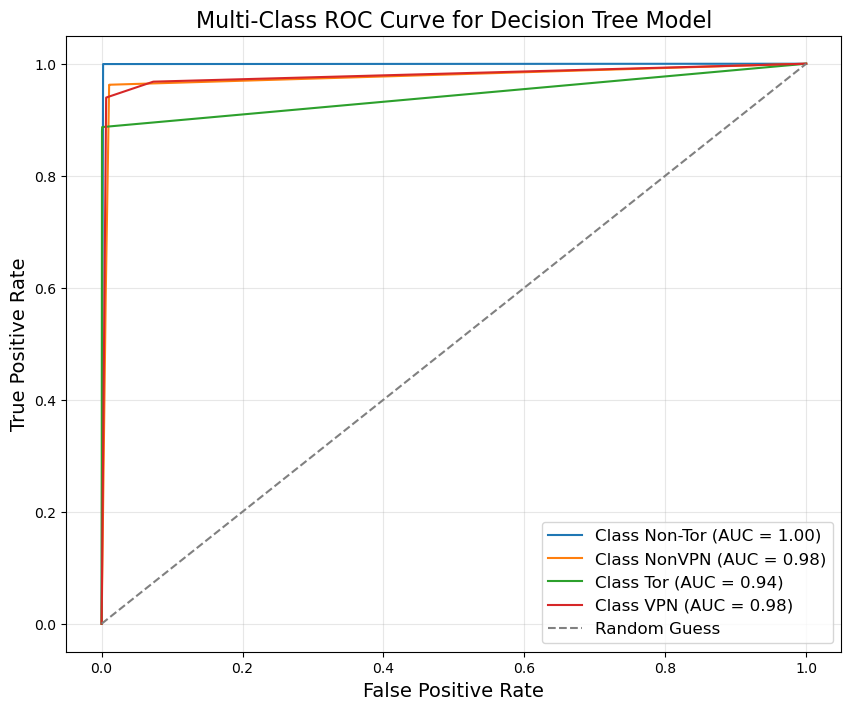

In [60]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize


y_test_binarized = label_binarize(y_test, classes=np.unique(y))
n_classes = y_test_binarized.shape[1]


y_score = best_dt_model.predict_proba(X_test_selected)


plt.figure(figsize=(10, 8))


for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {le.classes_[i]} (AUC = {roc_auc:.2f})') 


plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random Guess')


plt.title('Multi-Class ROC Curve for Decision Tree Model', fontsize=16)
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.legend(loc='lower right', fontsize=12)
plt.grid(alpha=0.3)
plt.show()


## For Label 1 I made a pipe line to learn more about ML pipelines

In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158117 entries, 0 to 158116
Data columns (total 68 columns):
 #   Column                      Non-Null Count   Dtype   
---  ------                      --------------   -----   
 0   Flow ID                     158117 non-null  category
 1   Src IP                      158117 non-null  category
 2   Src Port                    158117 non-null  float64 
 3   Dst IP                      158117 non-null  category
 4   Dst Port                    158117 non-null  float64 
 5   Protocol                    158117 non-null  float64 
 6   Timestamp                   158117 non-null  category
 7   Flow Duration               158117 non-null  float64 
 8   Total Fwd Packet            158117 non-null  float64 
 9   Total Bwd packets           158117 non-null  float64 
 10  Total Length of Fwd Packet  158117 non-null  float64 
 11  Total Length of Bwd Packet  158117 non-null  float64 
 12  Fwd Packet Length Max       158117 non-null  float64 
 13 

## Putting it all together for Second Label, Communication Type
### Note this part takes a bit long, since it combines so many things

Selected features: Index(['Src Port', 'Dst Port', 'Flow Duration', 'Total Bwd packets',
       'Fwd Packet Length Mean', 'Bwd Packet Length Min', 'Packet Length Max',
       'FWD Init Win Bytes', 'Bwd Init Win Bytes', 'Idle Max'],
      dtype='object')

Model Performance Metrics with SMOTE and StandardScaler:
           Model  Accuracy  Precision    Recall  F1 Score  CV Mean Accuracy
0  Decision Tree  0.916603   0.918351  0.916603  0.917236          0.911945


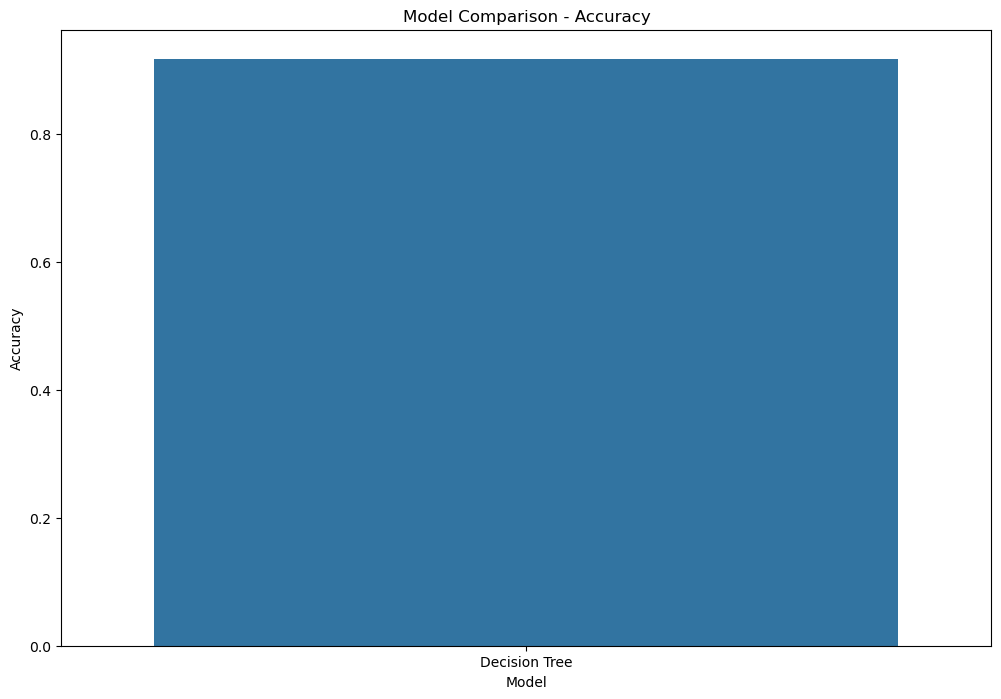

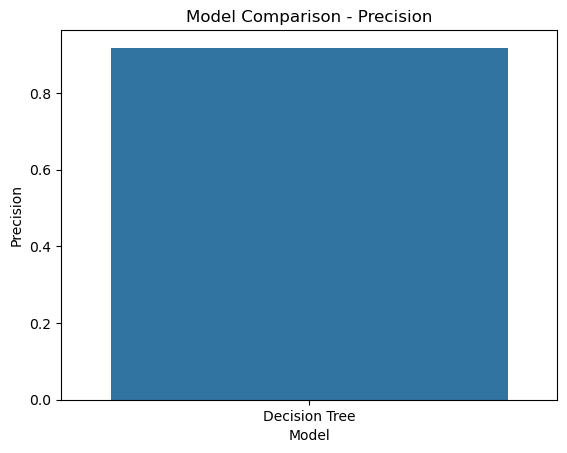

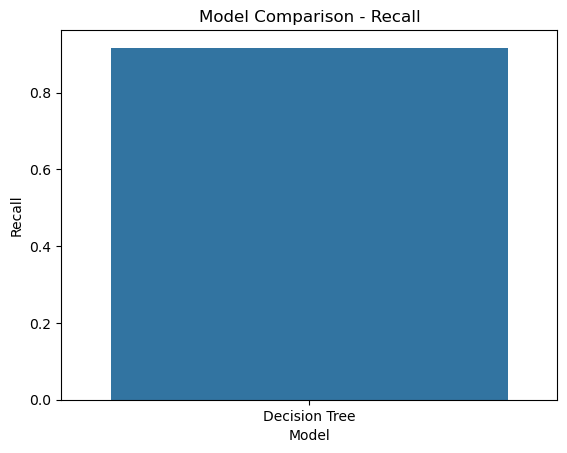

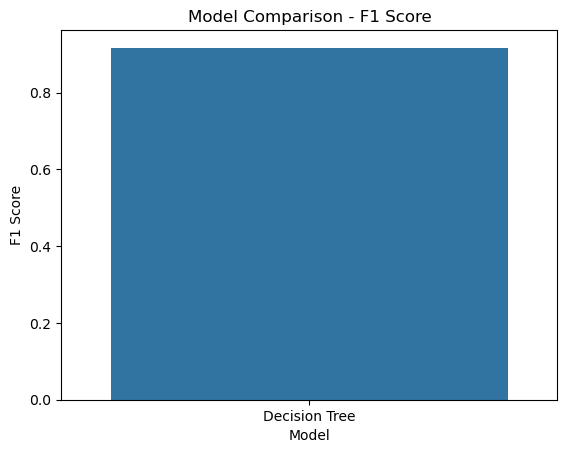

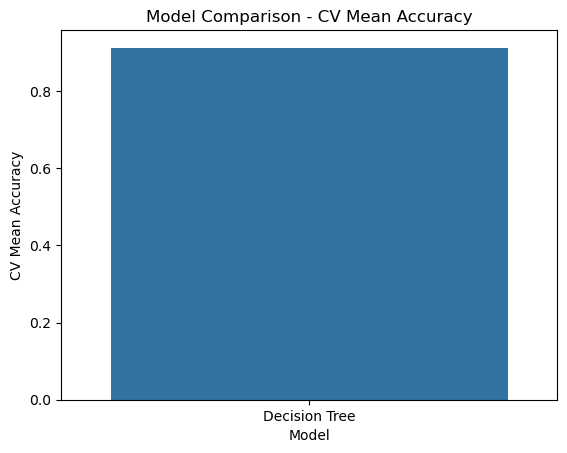


Classification Report for Decision Tree with SMOTE and StandardScaler:
              precision    recall  f1-score   support

           0       0.90      0.89      0.90      6373
           1       0.97      0.96      0.96     13927
           2       0.85      0.78      0.81      3484
           3       0.74      0.80      0.77      1841
           4       0.83      0.86      0.85      3329
           5       1.00      1.00      1.00     14499
           6       0.58      0.62      0.60      1068
           7       0.73      0.78      0.75      2915

    accuracy                           0.92     47436
   macro avg       0.83      0.84      0.83     47436
weighted avg       0.92      0.92      0.92     47436



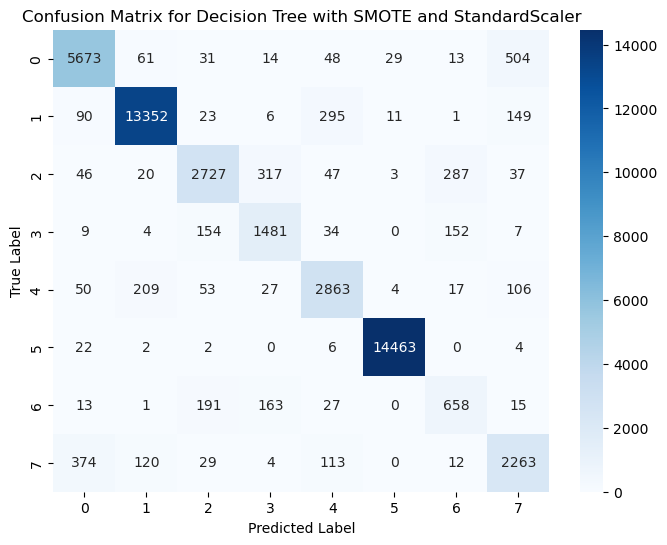


Feature Importances:
Idle Max                  0.235480
Src Port                  0.174753
Flow Duration             0.155772
Dst Port                  0.154776
FWD Init Win Bytes        0.059990
Total Bwd packets         0.055706
Bwd Packet Length Min     0.053315
Packet Length Max         0.042033
Bwd Init Win Bytes        0.037793
Fwd Packet Length Mean    0.030383
dtype: float64


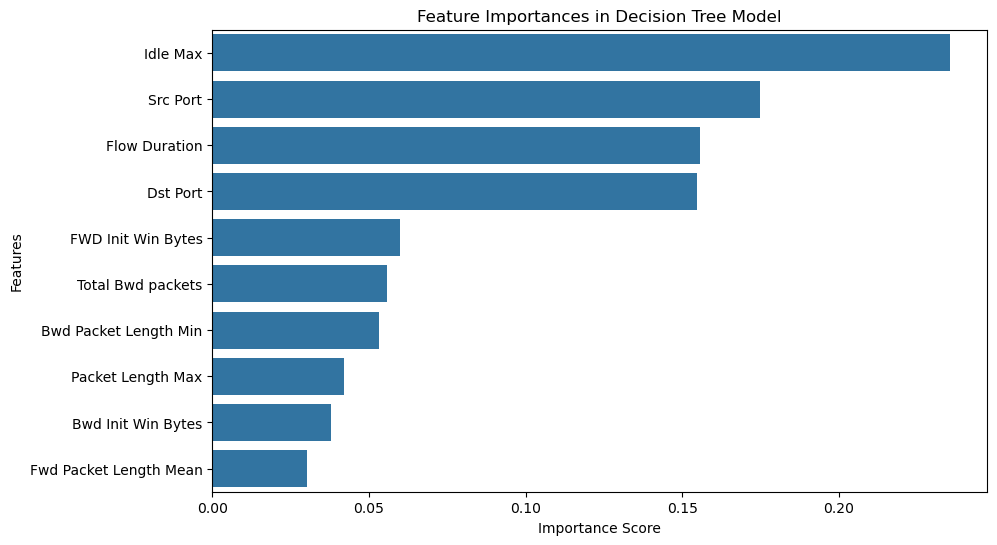

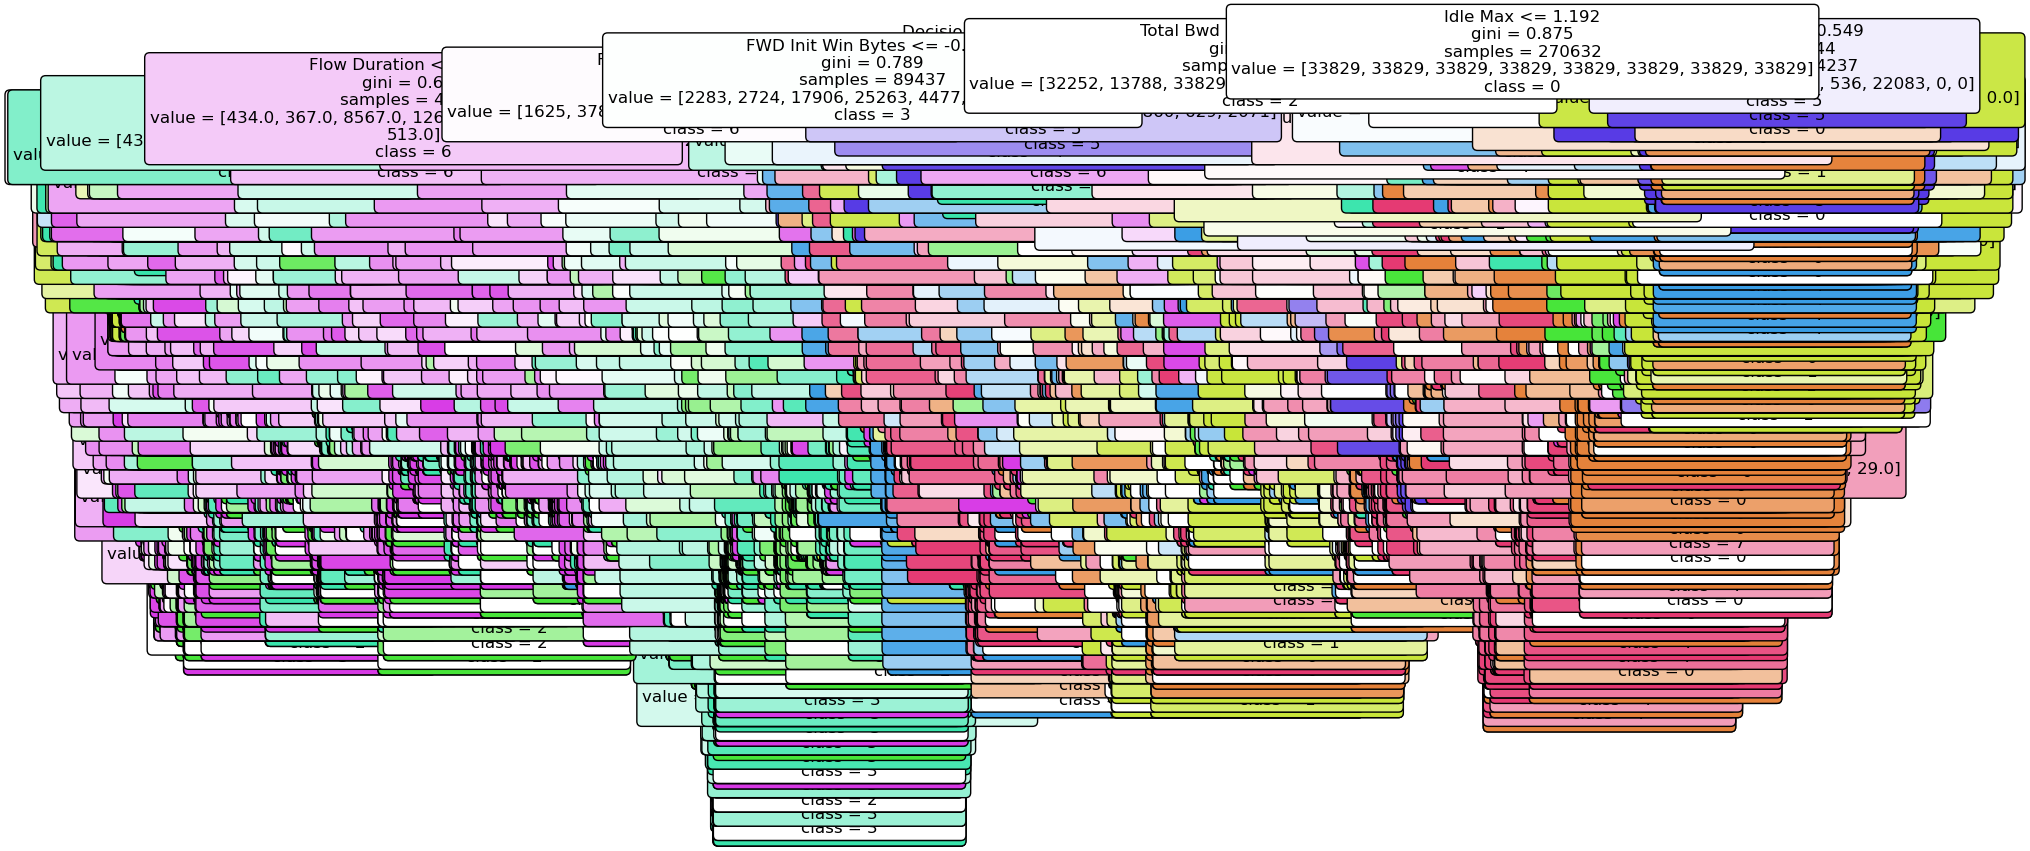


Cross-Validation Scores for Decision Tree: [0.91042147 0.91141128 0.91240513 0.91177268 0.91371522]
Mean Cross-Validation Score: 0.9119

Best Parameters from Grid Search: {'classifier__criterion': 'entropy', 'classifier__max_depth': None, 'classifier__min_samples_split': 2}

Classification Report for Tuned Decision Tree with SMOTE and StandardScaler:
              precision    recall  f1-score   support

           0       0.90      0.89      0.90      6373
           1       0.97      0.96      0.96     13927
           2       0.85      0.79      0.82      3484
           3       0.75      0.80      0.77      1841
           4       0.85      0.86      0.86      3329
           5       1.00      1.00      1.00     14499
           6       0.58      0.63      0.60      1068
           7       0.74      0.79      0.76      2915

    accuracy                           0.92     47436
   macro avg       0.83      0.84      0.83     47436
weighted avg       0.92      0.92      0.92     47

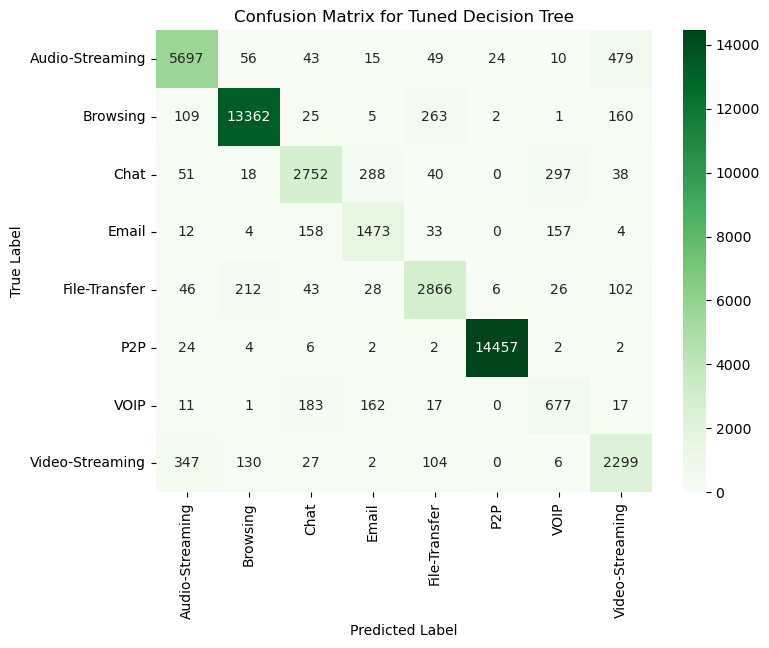


Feature Importances for Tuned Model:
Idle Max                  0.283206
Dst Port                  0.135775
Src Port                  0.135722
Flow Duration             0.124004
FWD Init Win Bytes        0.099733
Total Bwd packets         0.084283
Bwd Packet Length Min     0.044950
Packet Length Max         0.042868
Fwd Packet Length Mean    0.026076
Bwd Init Win Bytes        0.023384
dtype: float64


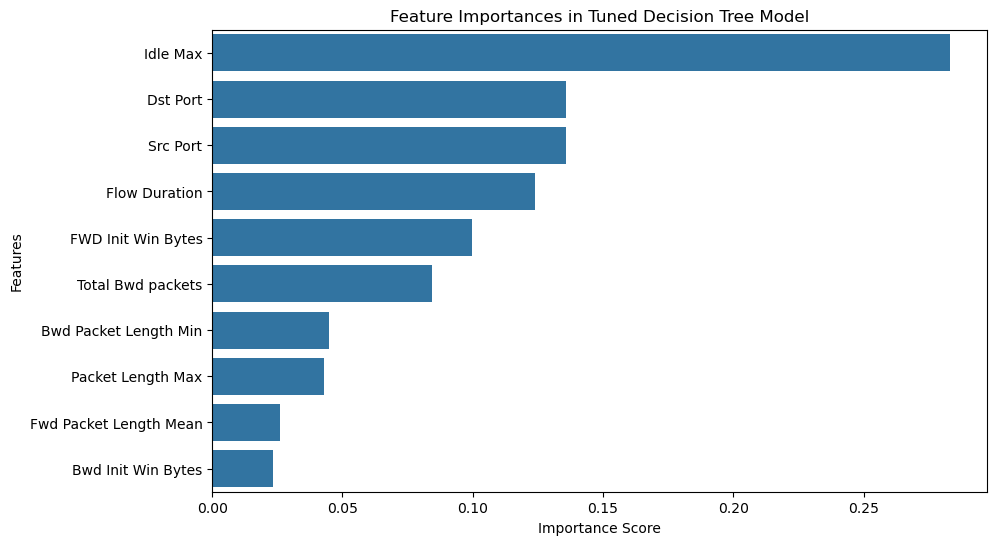

In [64]:


## add the original label back
df["Label.1"] = last_label
df['Label.1'] = le_LabelOne.fit_transform(df['Label.1'])

# remove the label to avoid label the other label relying on the first label
df = df.drop(columns=["Label"])
numeric_df = df.select_dtypes(include=['number'])


if 'Label.1' in numeric_df.columns:
    target_column = 'Label.1'
else:
    raise ValueError("Label 1 not found in the dataset.")



X = numeric_df.drop(columns=[target_column]) 
y = numeric_df[target_column]  





X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)


base_model = DecisionTreeClassifier(random_state=42)


sfs = SequentialFeatureSelector(
    base_model,
    n_features_to_select=10,  
    direction='forward',
    scoring='accuracy',
    cv=5,  
    n_jobs=-1
)


sfs.fit(X_train_full, y_train_full)


selected_features = X_train_full.columns[sfs.get_support()]

print("Selected features:", selected_features)


X_train_full_selected = X_train_full[selected_features]
X_test_selected = X_test[selected_features]

# Now, retrain model


models = {

     "Decision Tree": DecisionTreeClassifier(random_state=42),

}

smote = SMOTE(random_state=42)


results = []
model_predictions = {}

# using stratified K fold instead of just normal cross validation for better results, trying to get best in the last piple line
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for model_name, model in models.items():
    # create a pipeline with SMOTE, StandardScaler, and the model
    pipeline = ImbPipeline([
        ('smote', smote),
        ('scaler', StandardScaler()),
        ('classifier', model)
    ])
    

    pipeline.fit(X_train_full_selected, y_train_full)
    

    y_pred = pipeline.predict(X_test_selected)
    model_predictions[model_name] = y_pred  
    

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
    

    cv_scores = cross_val_score(pipeline, X_train_full_selected, y_train_full, cv=skf, scoring='accuracy', n_jobs=-1)
    cv_mean = cv_scores.mean()
 
    results.append(
        {
            "Model": model_name,
            "Accuracy": accuracy,
            "Precision": precision,
            "Recall": recall,
            "F1 Score": f1,
            "CV Mean Accuracy": cv_mean
        }
    )


results_df = pd.DataFrame(results)
print("\nModel Performance Metrics with SMOTE and StandardScaler:")
print(results_df)

# Visualize Model Performance
plt.figure(figsize=(12, 8))
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'CV Mean Accuracy']
for metric in metrics:
    sns.barplot(x='Model', y=metric, data=results_df)
    plt.title(f'Model Comparison - {metric}')
    plt.ylabel(metric)
    plt.xlabel('Model')
    plt.show()


# now train the pipeline with the selected features, to compare the difference between selected feattues and all features
dt_pipeline = ImbPipeline([
    ('smote', smote),
    ('scaler', StandardScaler()),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

# Fit the pipeline
dt_pipeline.fit(X_train_full_selected, y_train_full)


y_pred_dt = dt_pipeline.predict(X_test_selected)


print("\nClassification Report for Decision Tree with SMOTE and StandardScaler:")
print(classification_report(y_test, y_pred_dt))


cm = confusion_matrix(y_test, y_pred_dt)
cm_df = pd.DataFrame(cm, index=np.unique(y), columns=np.unique(y))


plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for Decision Tree with SMOTE and StandardScaler')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


dt_model = dt_pipeline.named_steps['classifier']
feature_importances = pd.Series(dt_model.feature_importances_, index=selected_features)
feature_importances.sort_values(ascending=False, inplace=True)

print("\nFeature Importances:")
print(feature_importances)

# Visualize Feature Importances
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances, y=feature_importances.index)
plt.title('Feature Importances in Decision Tree Model')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()


# plt.figure(figsize=(20, 10))
# plot_tree(
#     dt_model,
#     feature_names=selected_features,
#     class_names=dt_model.classes_.astype(str),
#     filled=True,
#     rounded=True,
#     fontsize=12,
# )
# plt.title('Decision Tree Visualization')
# plt.show()

# Cross-Validation 
cv_scores_dt = cross_val_score(dt_pipeline, X_train_full_selected, y_train_full, cv=skf, scoring='accuracy', n_jobs=-1)
print(f"\nCross-Validation Scores for Decision Tree: {cv_scores_dt}")
print(f"Mean Cross-Validation Score: {cv_scores_dt.mean():.4f}")

# Hyperparameter Tuning 
param_grid = {
    'classifier__max_depth': [None, 5, 10, 15],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__criterion': ['gini', 'entropy']
}

grid_search = GridSearchCV(
    dt_pipeline,
    param_grid,
    cv=skf,
    scoring='accuracy',
    n_jobs=-1
)
grid_search.fit(X_train_full_selected, y_train_full)

print(f"\nBest Parameters from Grid Search: {grid_search.best_params_}")
best_dt_pipeline = grid_search.best_estimator_

# Evaluate the Tuned Model
y_pred_tuned = best_dt_pipeline.predict(X_test_selected)
print("\nClassification Report for Tuned Decision Tree with SMOTE and StandardScaler:")
print(classification_report(y_test, y_pred_tuned))


cm_tuned = confusion_matrix(y_test, y_pred_tuned)
cm_tuned_df = pd.DataFrame(cm_tuned, index=np.unique(y), columns=np.unique(y))


original_labels_label_one = le_LabelOne.classes_


cm_tuned = confusion_matrix(y_test, y_pred_tuned)
cm_tuned_df = pd.DataFrame(cm_tuned, index=original_labels_label_one, columns=original_labels_label_one)


plt.figure(figsize=(8, 6))
sns.heatmap(cm_tuned_df, annot=True, fmt='d', cmap='Greens')
plt.title('Confusion Matrix for Tuned Decision Tree')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()



best_dt_model = best_dt_pipeline.named_steps['classifier']
feature_importances_tuned = pd.Series(best_dt_model.feature_importances_, index=selected_features)
feature_importances_tuned.sort_values(ascending=False, inplace=True)

print("\nFeature Importances for Tuned Model:")
print(feature_importances_tuned)

# Visualize Tuned tree
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances_tuned, y=feature_importances_tuned.index)
plt.title('Feature Importances in Tuned Decision Tree Model')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()



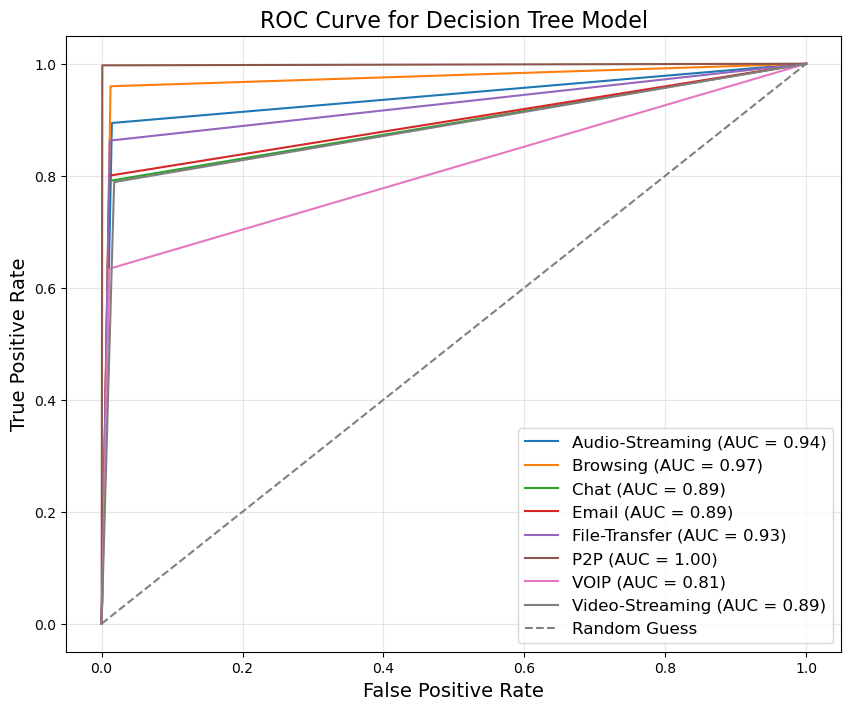

In [66]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize


original_labels_label_one = le_LabelOne.classes_


y_test_binarized = label_binarize(y_test, classes=np.unique(y))
n_classes = y_test_binarized.shape[1]


y_score = best_dt_pipeline.predict_proba(X_test_selected)


plt.figure(figsize=(10, 8))


for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{original_labels_label_one[i]} (AUC = {roc_auc:.2f})')

# Plot the diagonal (random guess)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random Guess')


plt.title('ROC Curve for Decision Tree Model', fontsize=16)
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.legend(loc='lower right', fontsize=12)
plt.grid(alpha=0.3)
plt.show()
